In [1]:
import scanpy as sc
import scFates as scf

In [2]:
adata=sc.read("adata_final.h5ad")

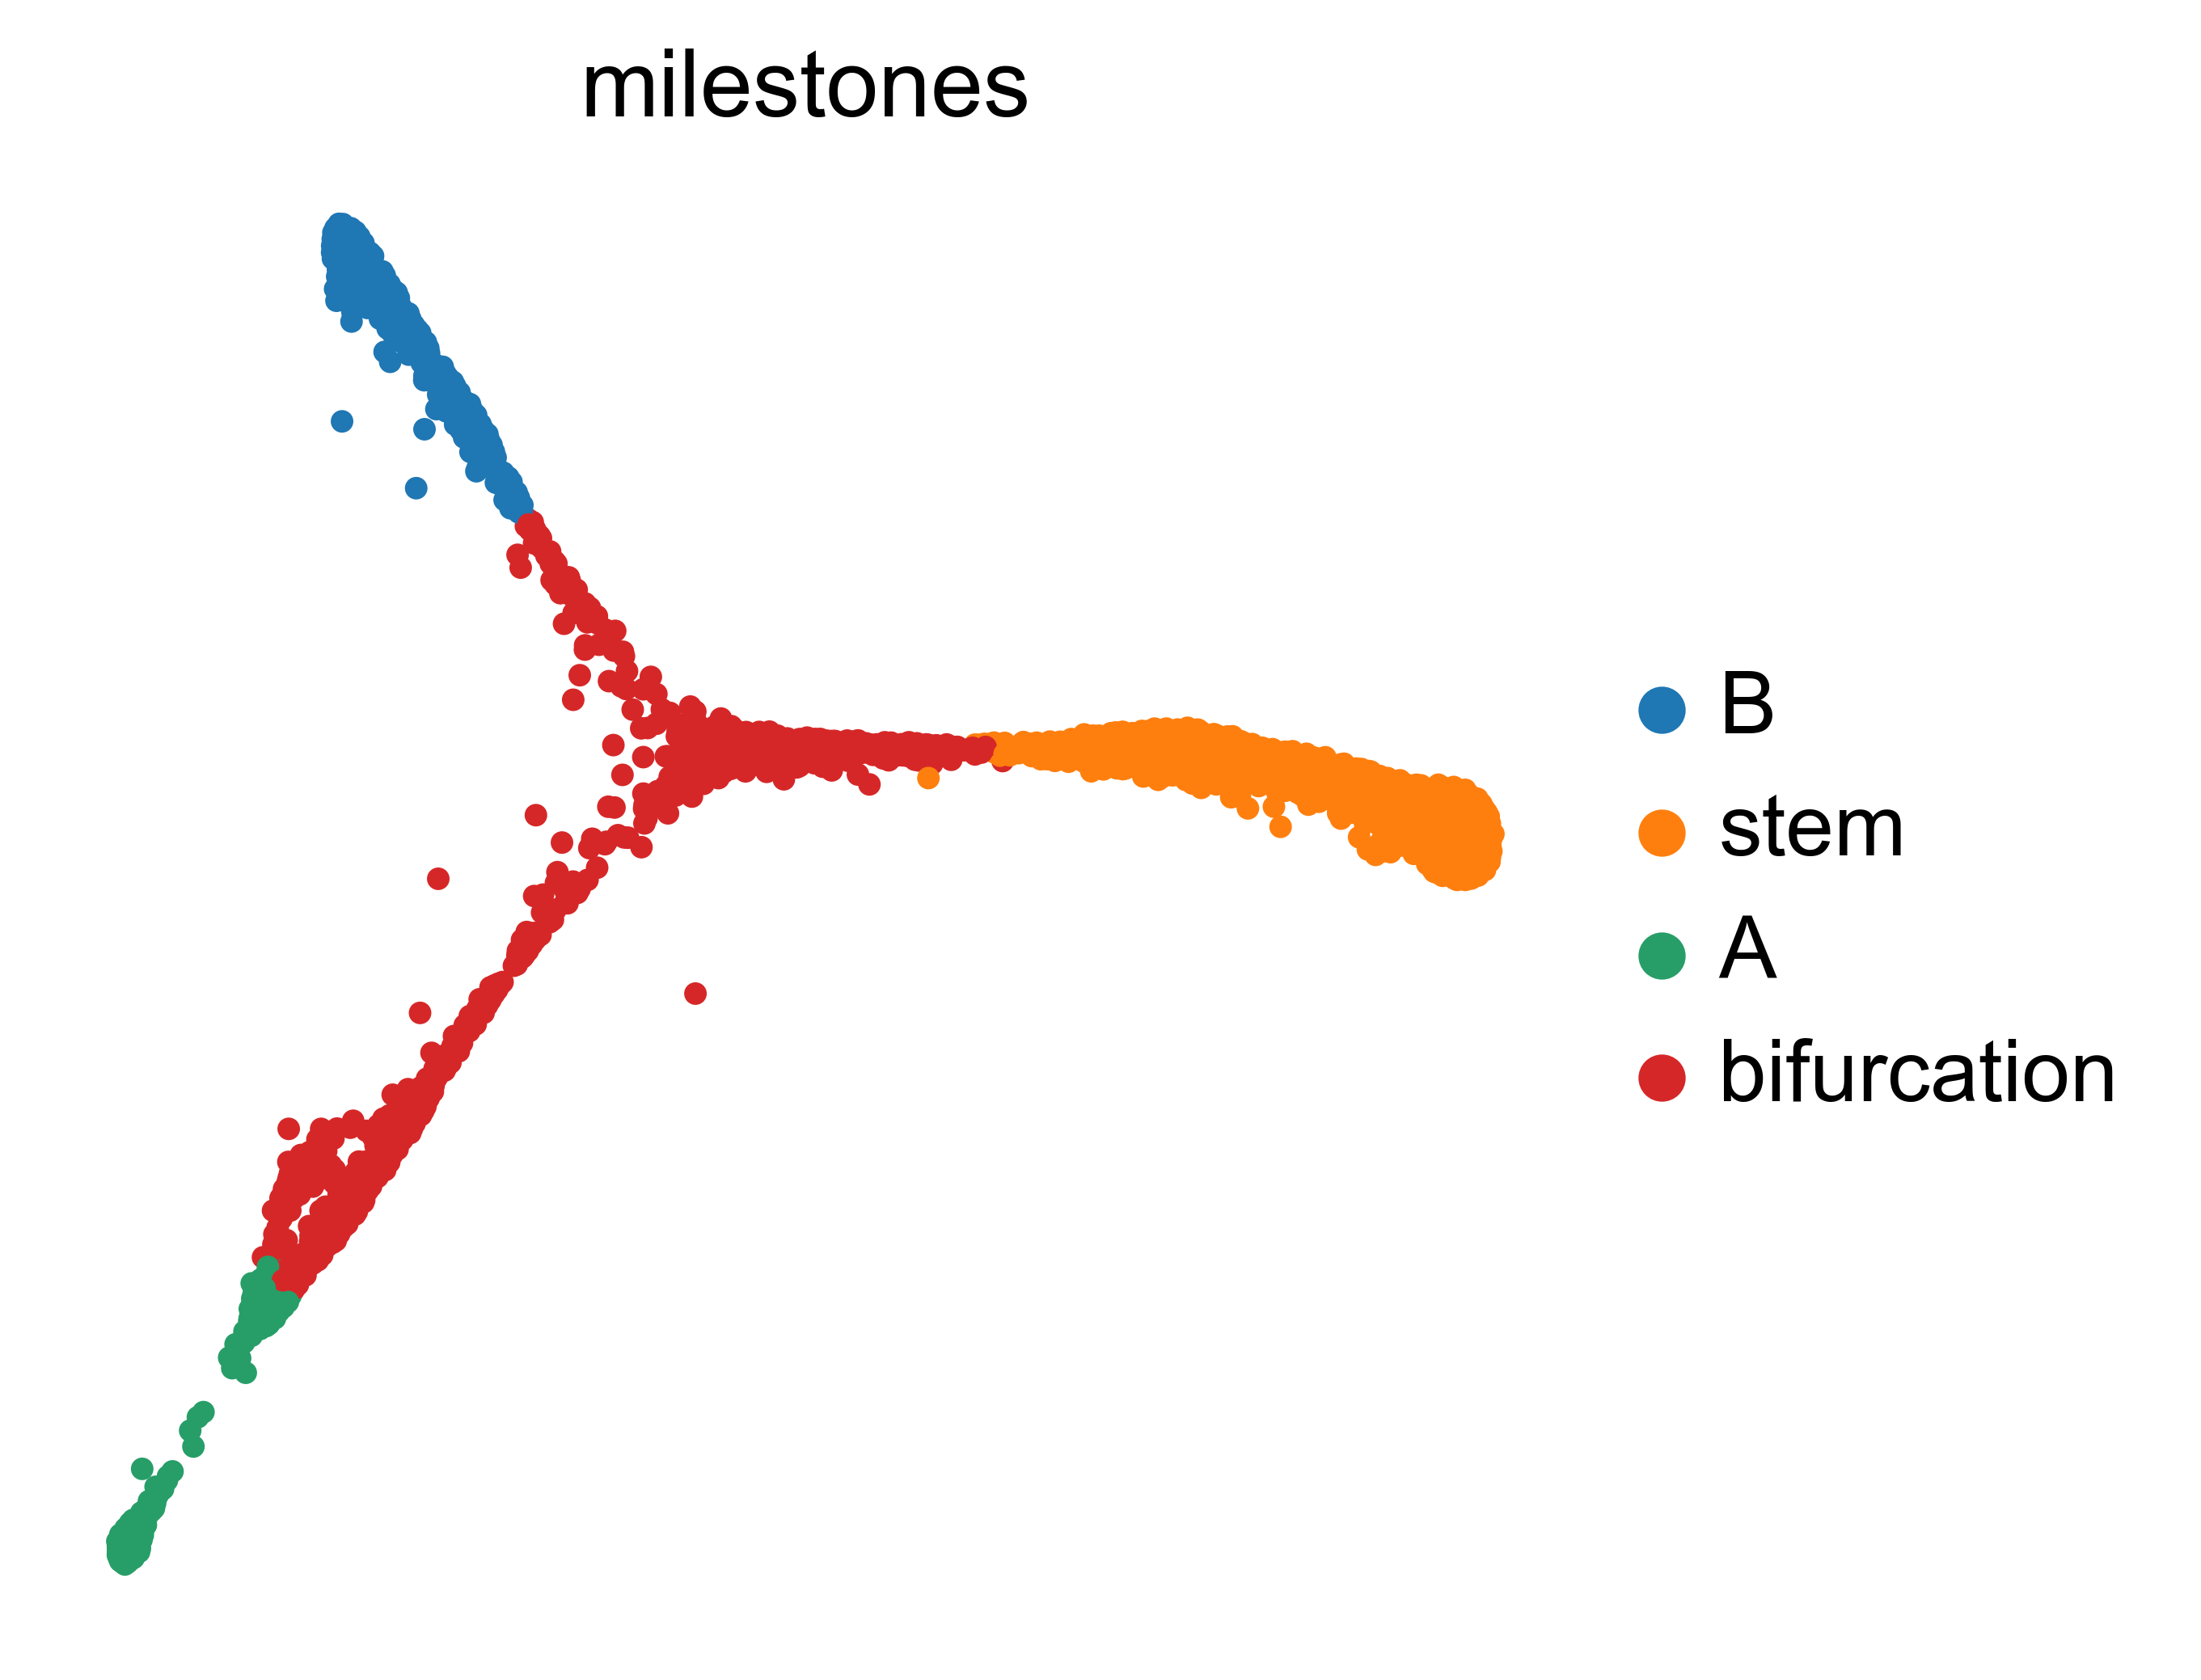

In [3]:
sc.set_figure_params(dpi=300,frameon=False)
scf.set_figure_pubready()
sc.pl.draw_graph(adata,color="milestones")

In [23]:
root_milestone="stem"

milestones=["bifurcation"]

In [24]:
from critical_transition import critical_transition

In [25]:
critical_transition(adata,root_milestone,milestones,w=50,step=15,n_jobs=10)

Calculating local critical transition index
    to bifurcation: 100%|██████████| 86/86 [00:16<00:00,  5.13it/s]
    finished (0:00:17) --> added 
    .uns['stem->bifurcation']['critical transition'], df containing local critical transition index per window of cells.
    .obs['stem->bifurcation CI'], local critical transition index projected onto cells.
    .obs['stem->bifurcation CI fitted'], GAM fit of local critical transition index projected onto cells.


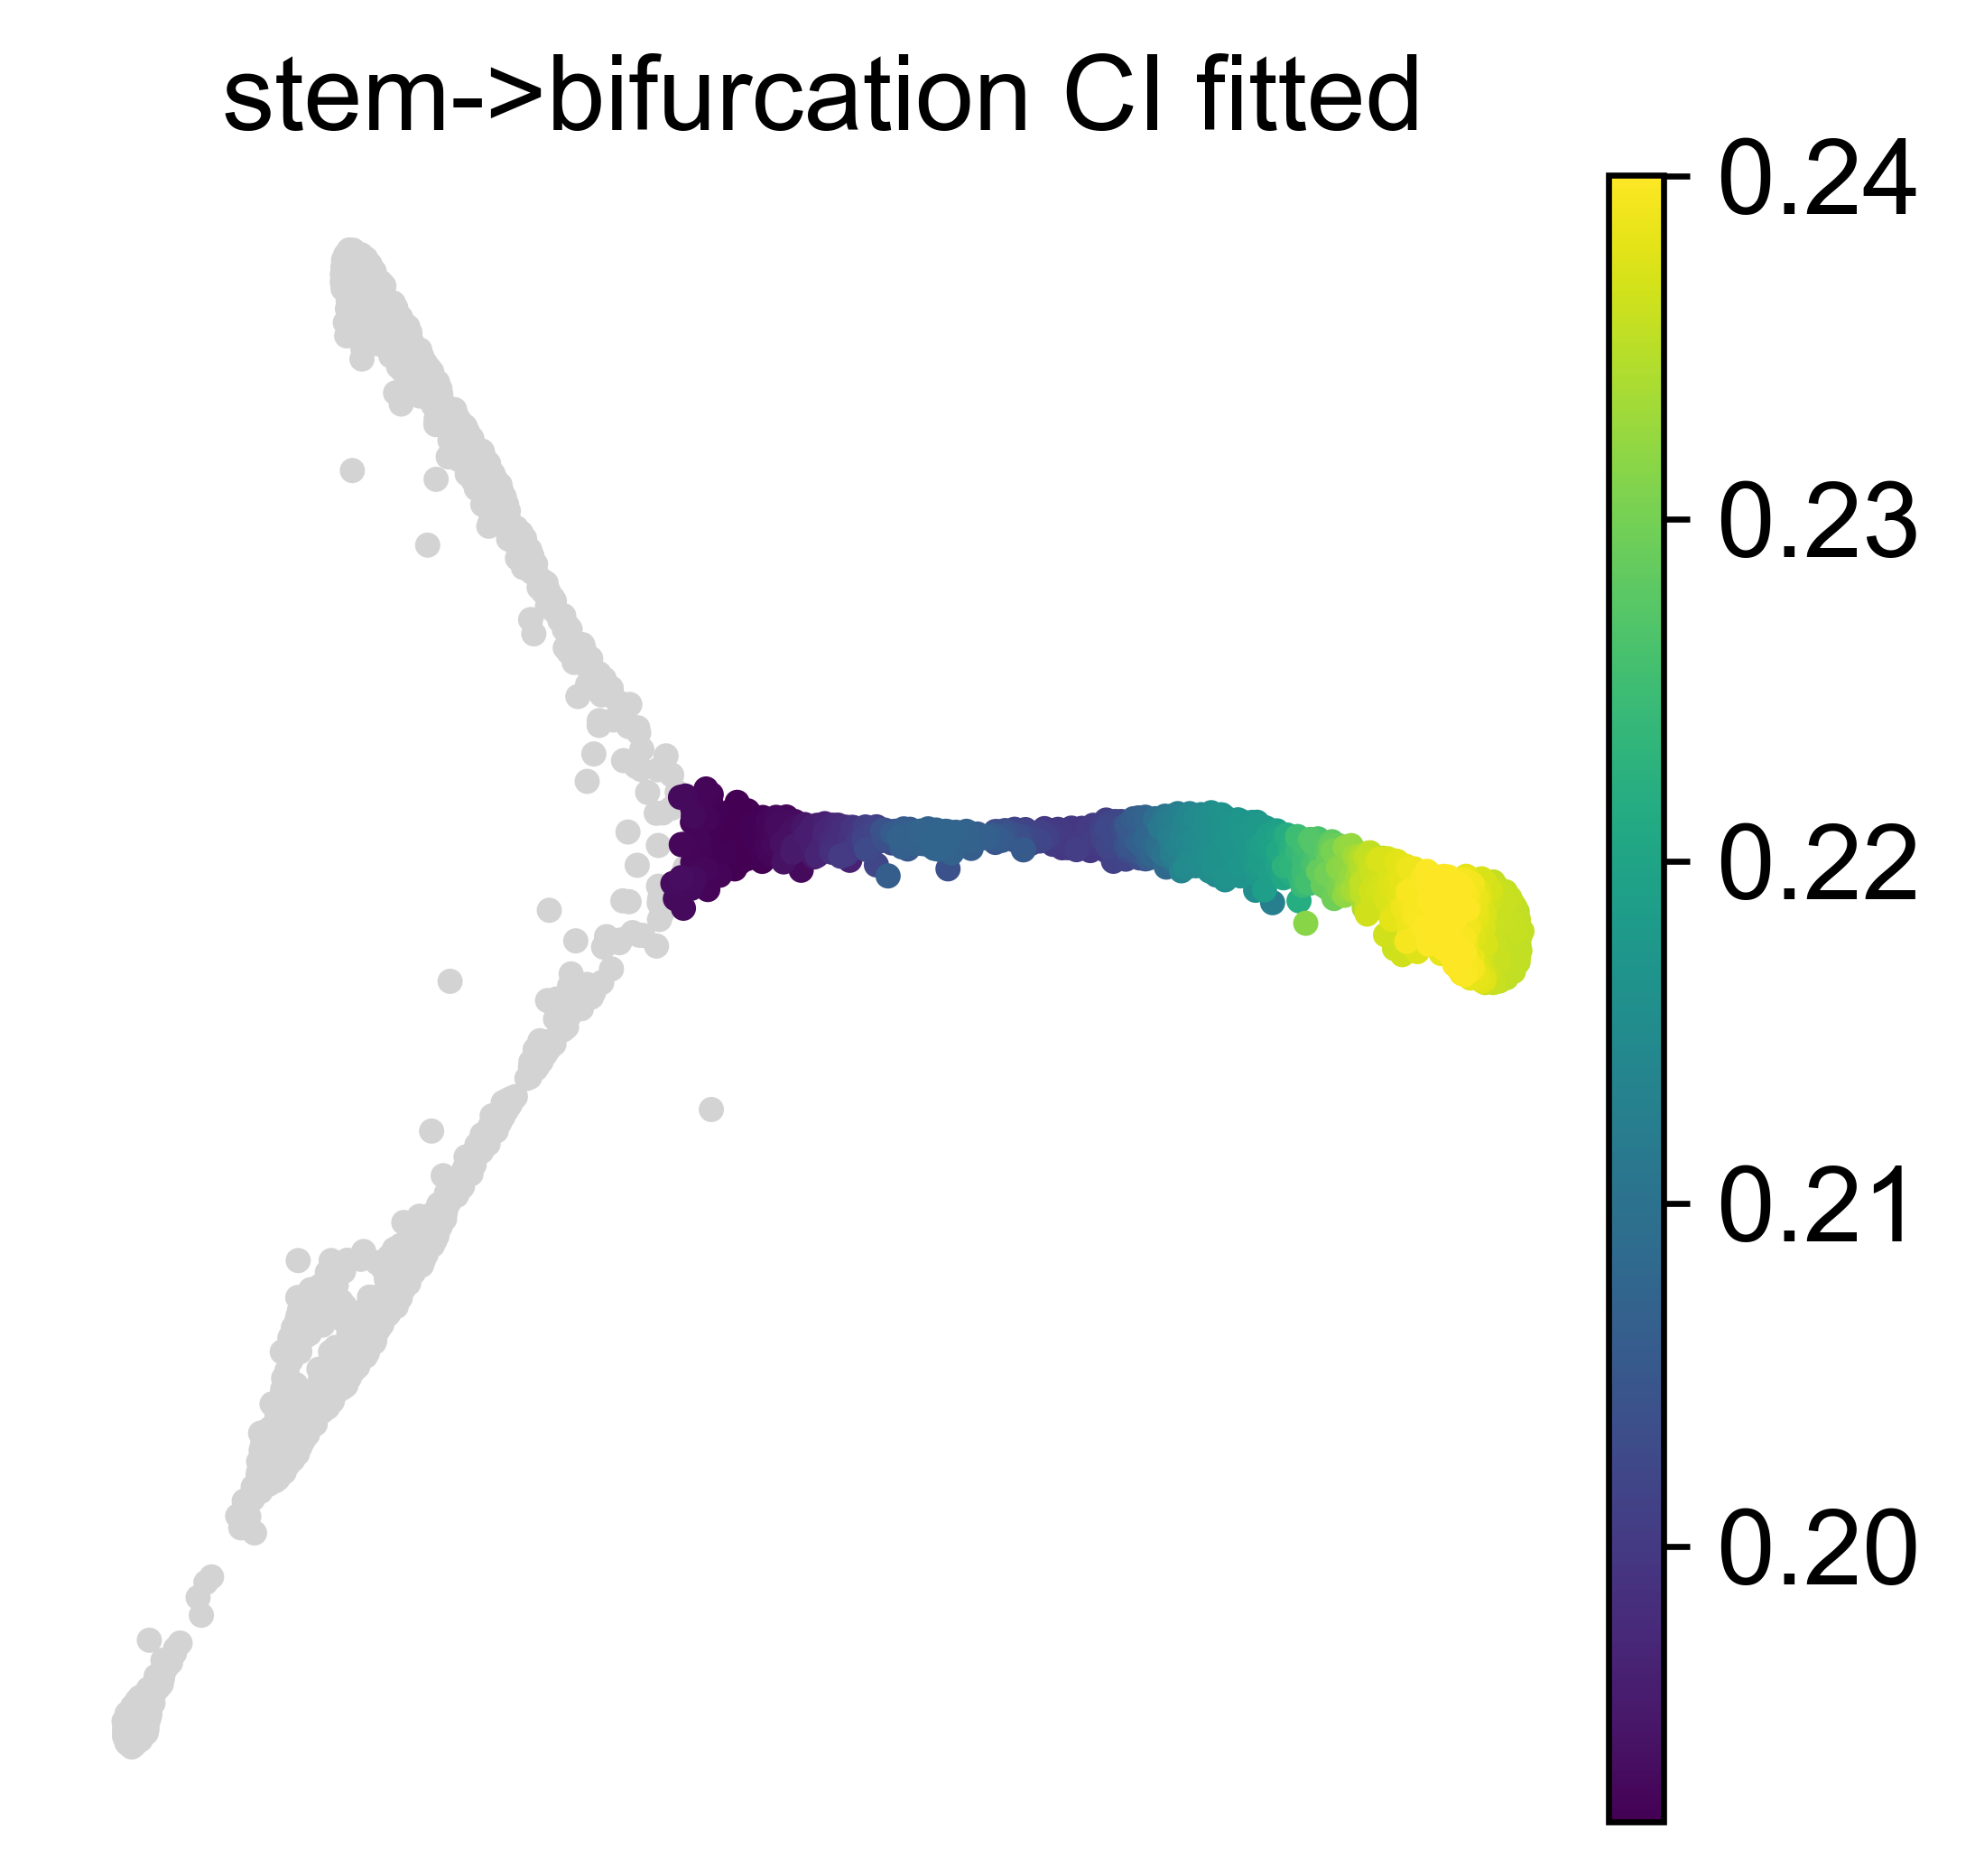

In [26]:
sc.pl.draw_graph(adata,color=f"{root_milestone}->{milestones[0]} CI fitted")

In [27]:
import matplotlib.pyplot as plt
from anndata import AnnData
from typing import Union, Optional
import igraph
import numpy as np
from scanpy.plotting._utils import savefig_or_show


def critical_transition_plot(
    adata: AnnData,
    root_milestone,
    milestones,
    col: Union[str, None] = None,
    show: Optional[bool] = None,
    save: Union[str, bool, None] = None,
):
    """\
    Plot results generated from tl.critical_transition.
    Parameters
    ----------
    adata
        Annotated data matrix.
    root_milestone
        tip defining progenitor branch.
    milestones
        tips defining the progenies branches.
    show
        show the plot.
    save
        save the plot.
    Returns
    -------
    If `show==False` a matrix of :class:`~matplotlib.axes.Axes`
    """

    name = root_milestone + "->" + "<>".join(milestones)
    mlsc = np.array(adata.uns["milestones_colors"].copy())

    if len(milestones) > 1:
        graph = adata.uns["graph"]

        edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
        img = igraph.Graph()
        img.add_vertices(
            np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
        )
        img.add_edges(edges)

        dct = graph["milestones"]
        leaves = list(map(lambda leave: dct[leave], milestones))
        root = dct[root_milestone]

        fork = list(
            set(img.get_shortest_paths(str(root), str(leaves[0]))[0]).intersection(
                img.get_shortest_paths(str(root), str(leaves[1]))[0]
            )
        )
        fork = np.array(img.vs["name"], dtype=int)[fork]
        fork_t = adata.uns["graph"]["pp_info"].loc[fork, "time"].max()

    fig, ax = plt.subplots()
    for p, df in adata.uns[name]["critical transition"].items():
        col = mlsc[adata.obs.milestones.cat.categories == p][0] if col is None else col
        ax.plot(df.t, df.ci, "+", c=col, zorder=10, alpha=0.3)
        ax.plot(df.t, df.GAM, c=col)
        ax.fill_between(
            df.t.values.tolist(),
            df.ll.tolist(),
            df.ul.tolist(),
            alpha=0.33,
            edgecolor=col,
            facecolor=col,
        )
        ax.set_xlabel("pseudotime")
        ax.set_ylabel("critical index")
        if len(milestones) > 1:
            ax.axvline(fork_t, color="black")

    savefig_or_show("critical_transition", show=show, save=save)

    if show == False:
        return ax

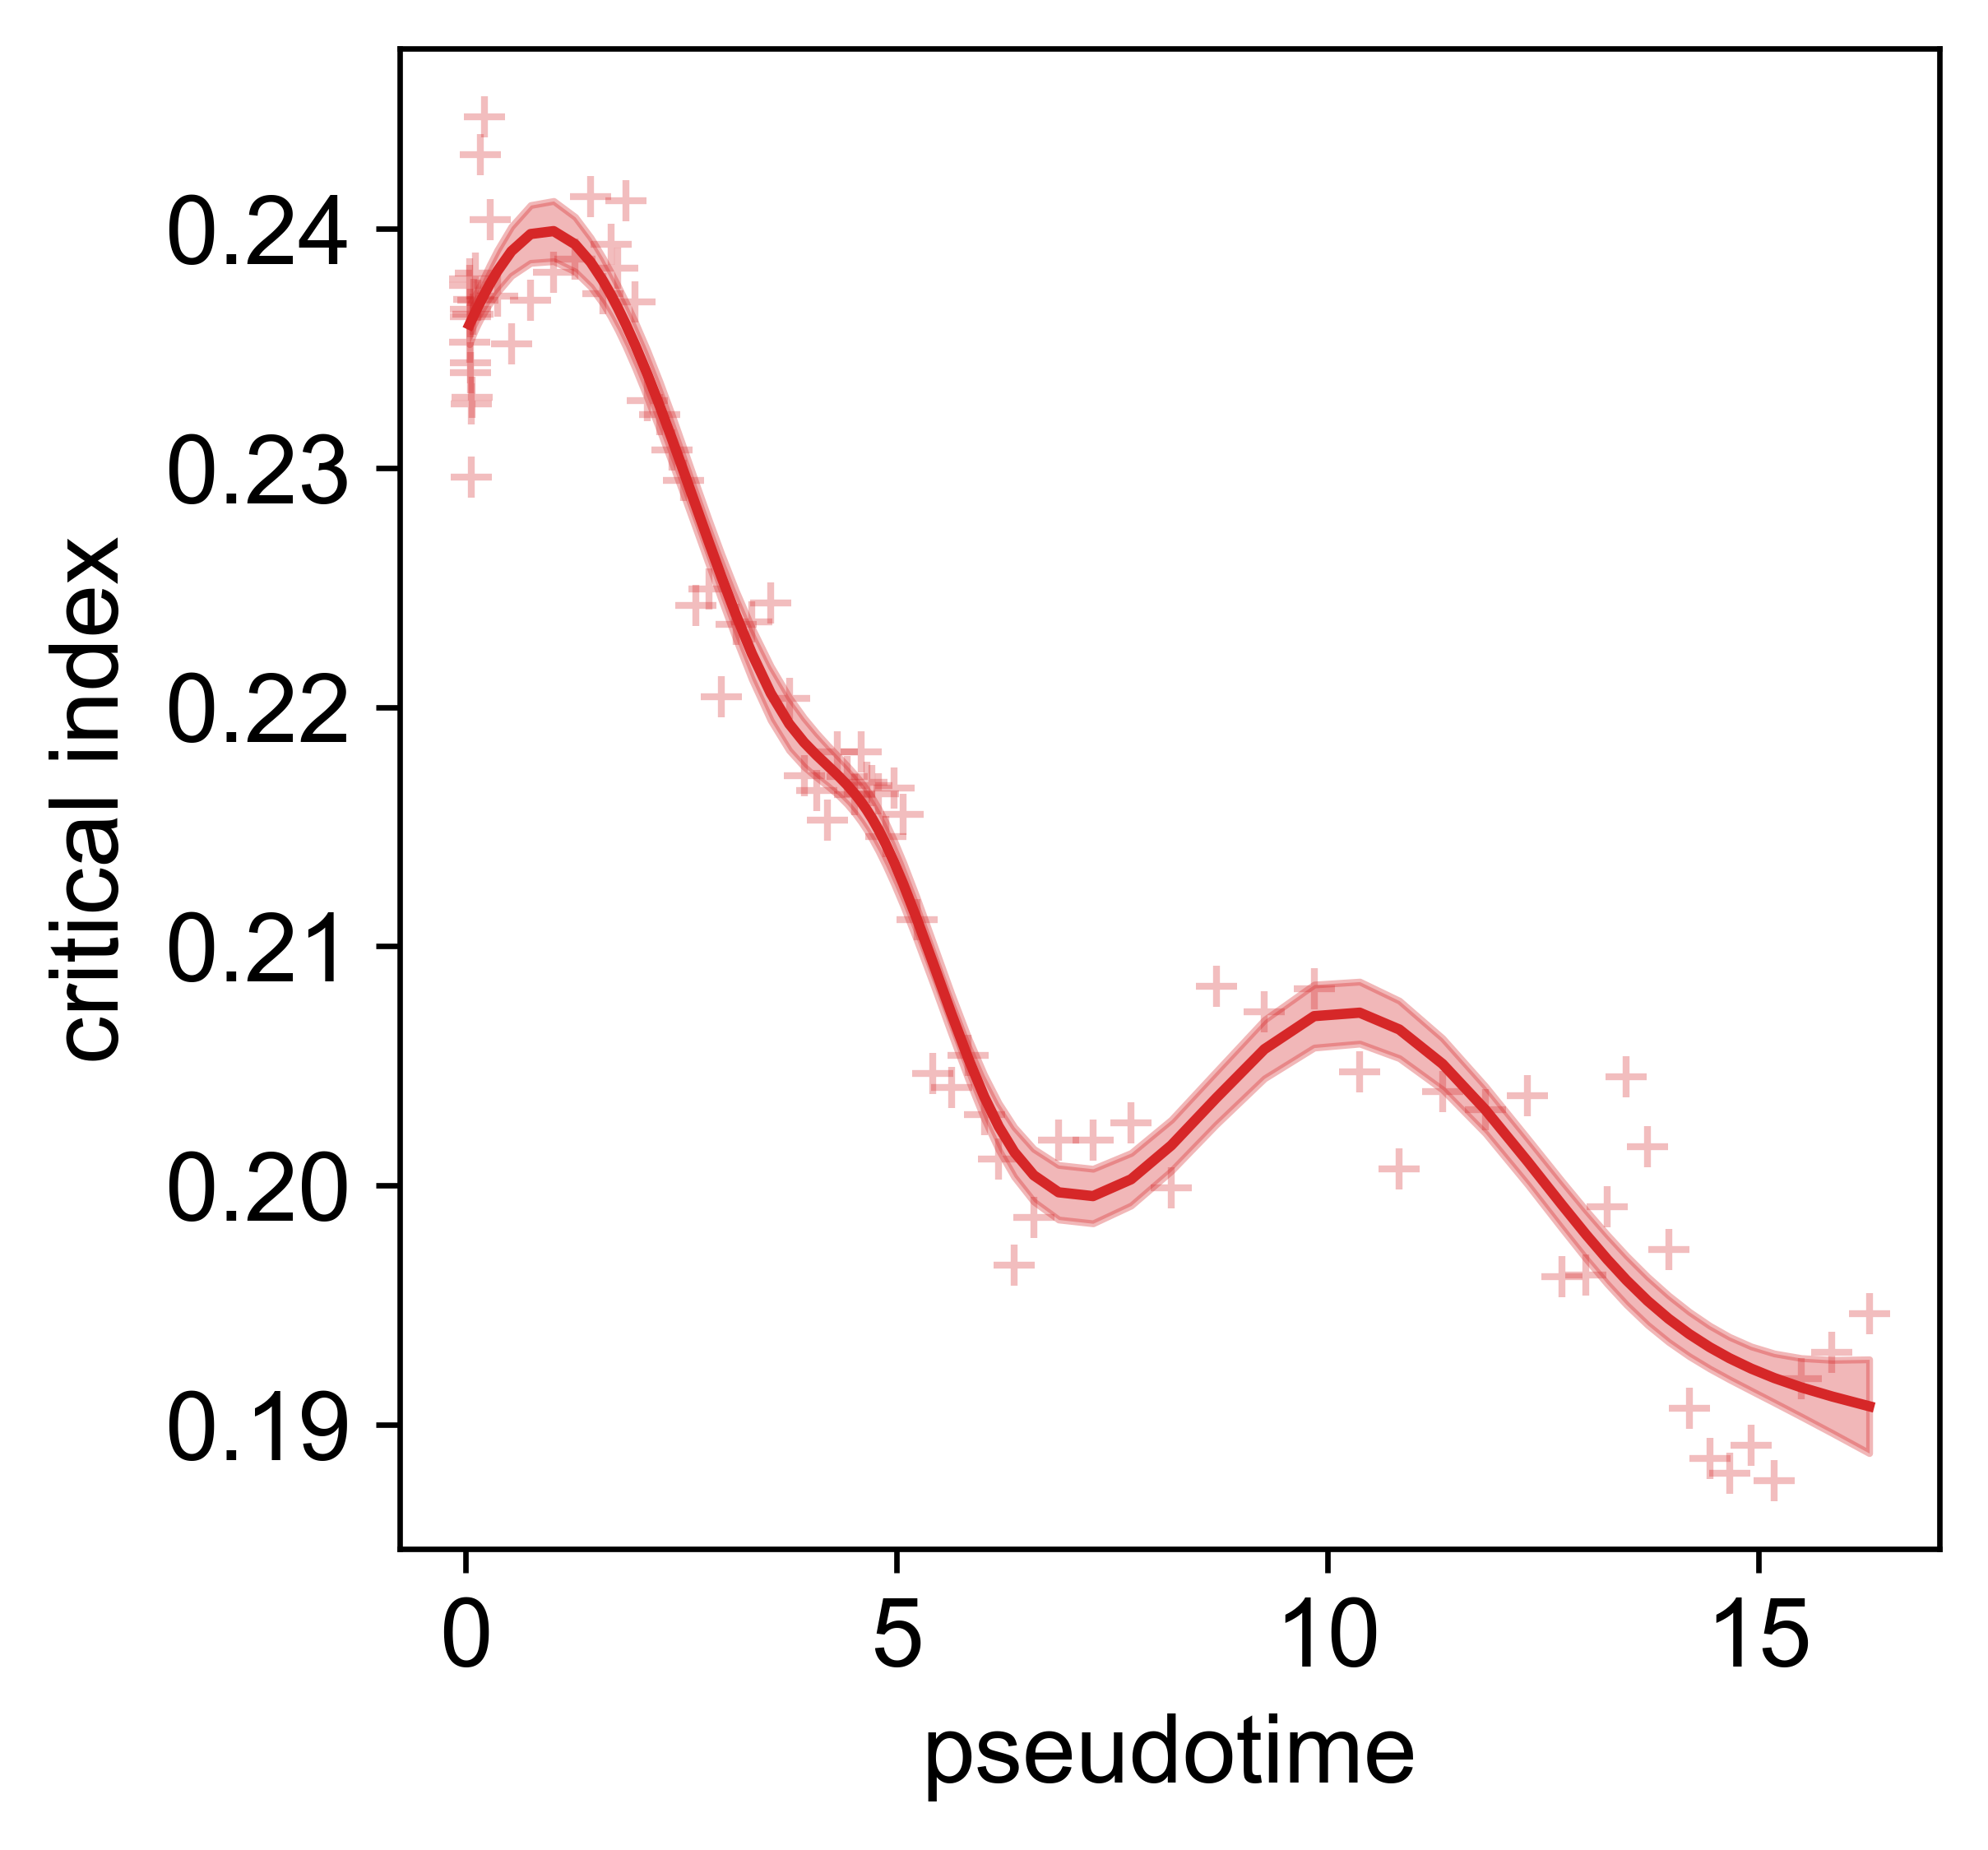

In [28]:
ax=critical_transition_plot(adata,root_milestone,milestones,show=False)

In [29]:
tA=adata.uns["graph"]["pp_info"].loc[adata.uns["graph"]["milestones"]["bifurcation"]].time

In [30]:
root_milestone="stem"
milestones=["A","B"]

scf.tl.synchro_path(adata,root_milestone,milestones,w=50,step=15,perm=False)

scf.tl.synchro_path(adata,root_milestone,["bifurcation"],w=50,step=15,
                    genesetA=scf.get.fork_stats(adata,root_milestone,milestones,module="early",branch=milestones[0]).index,
                    genesetB=scf.get.fork_stats(adata,root_milestone,milestones,module="early",branch=milestones[1]).index)

computing local correlations
    single mapping
    to B: 100%|██████████| 122/122 [00:01<00:00, 91.40it/s]
    finished (0:00:03) --> added 
    .uns['stem->A<>B']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor stem->A<>B'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.
computing local correlations
    single mapping
    to bifurcation: 100%|██████████| 86/86 [00:00<00:00, 94.35it/s]
    finished (0:00:02) --> added 
    .uns['stem->bifurcation']['synchro'], mean local gene-gene correlations of all possible gene pairs inside one module, or between the two modules.
    .obs['inter_cor stem->bifurcation'], GAM fit of inter-module mean local gene-gene correlations prior to bifurcation.


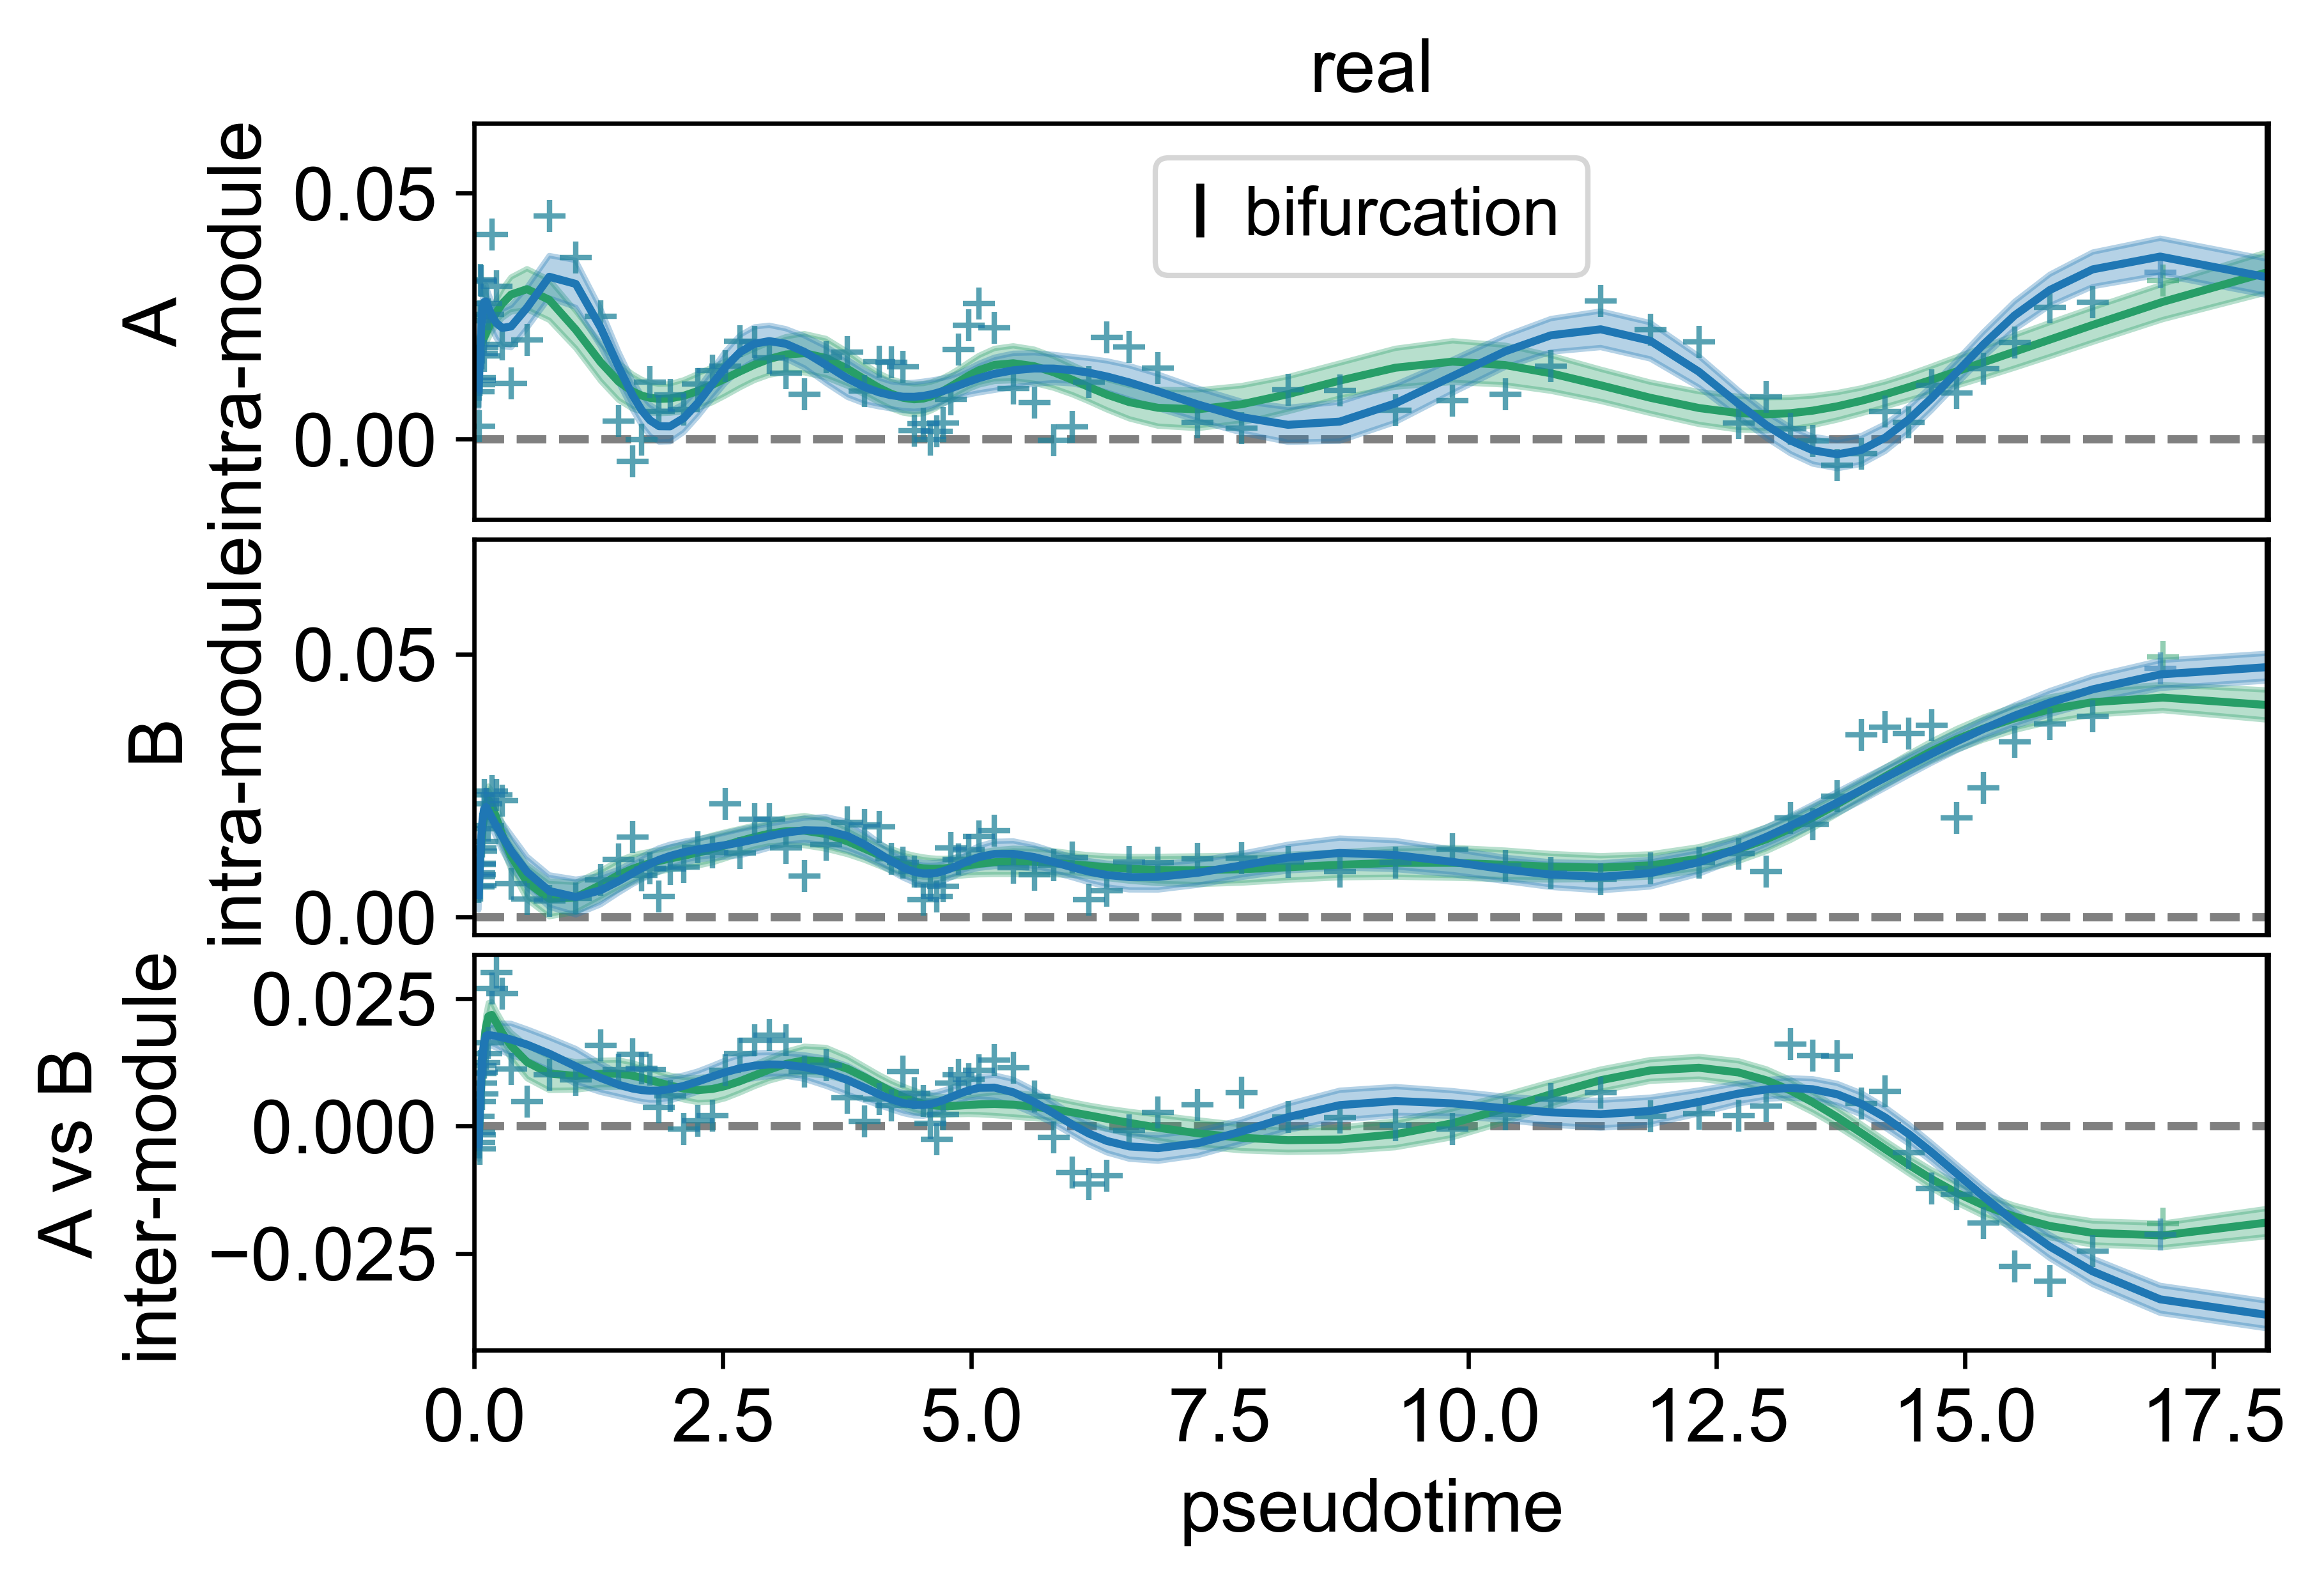

In [31]:
ax1,ax2,ax3=scf.pl.synchro_path(adata,root_milestone,milestones,knots=20,max_t=tA,figsize=(6,4),show=False)
#ax1.set_xlim([0.8,tA])
#ax2.set_xlim([0.8,tA])
#ax3.set_xlim([0.8,tA])
#ax3.set_ylabel("Hypo vs Seam c.\ninter-mod.")
#ax2.set_ylabel("Seam c.\nintra-mod.")
#ax1.set_ylabel("Hypo c.\nintra-mod.")


#ax3.set_xticks([0.8,tA],[root_milestone,"bifurcation"])

#xTick_objects = ax3.xaxis.get_major_ticks()

#xTick_objects[0].label1.set_horizontalalignment('left')   # left align first tick 
#xTick_objects[-1].label1.set_horizontalalignment('right')

plt.savefig("figures/synchro_path.pdf")

In [32]:
miles=["bifurcation"]

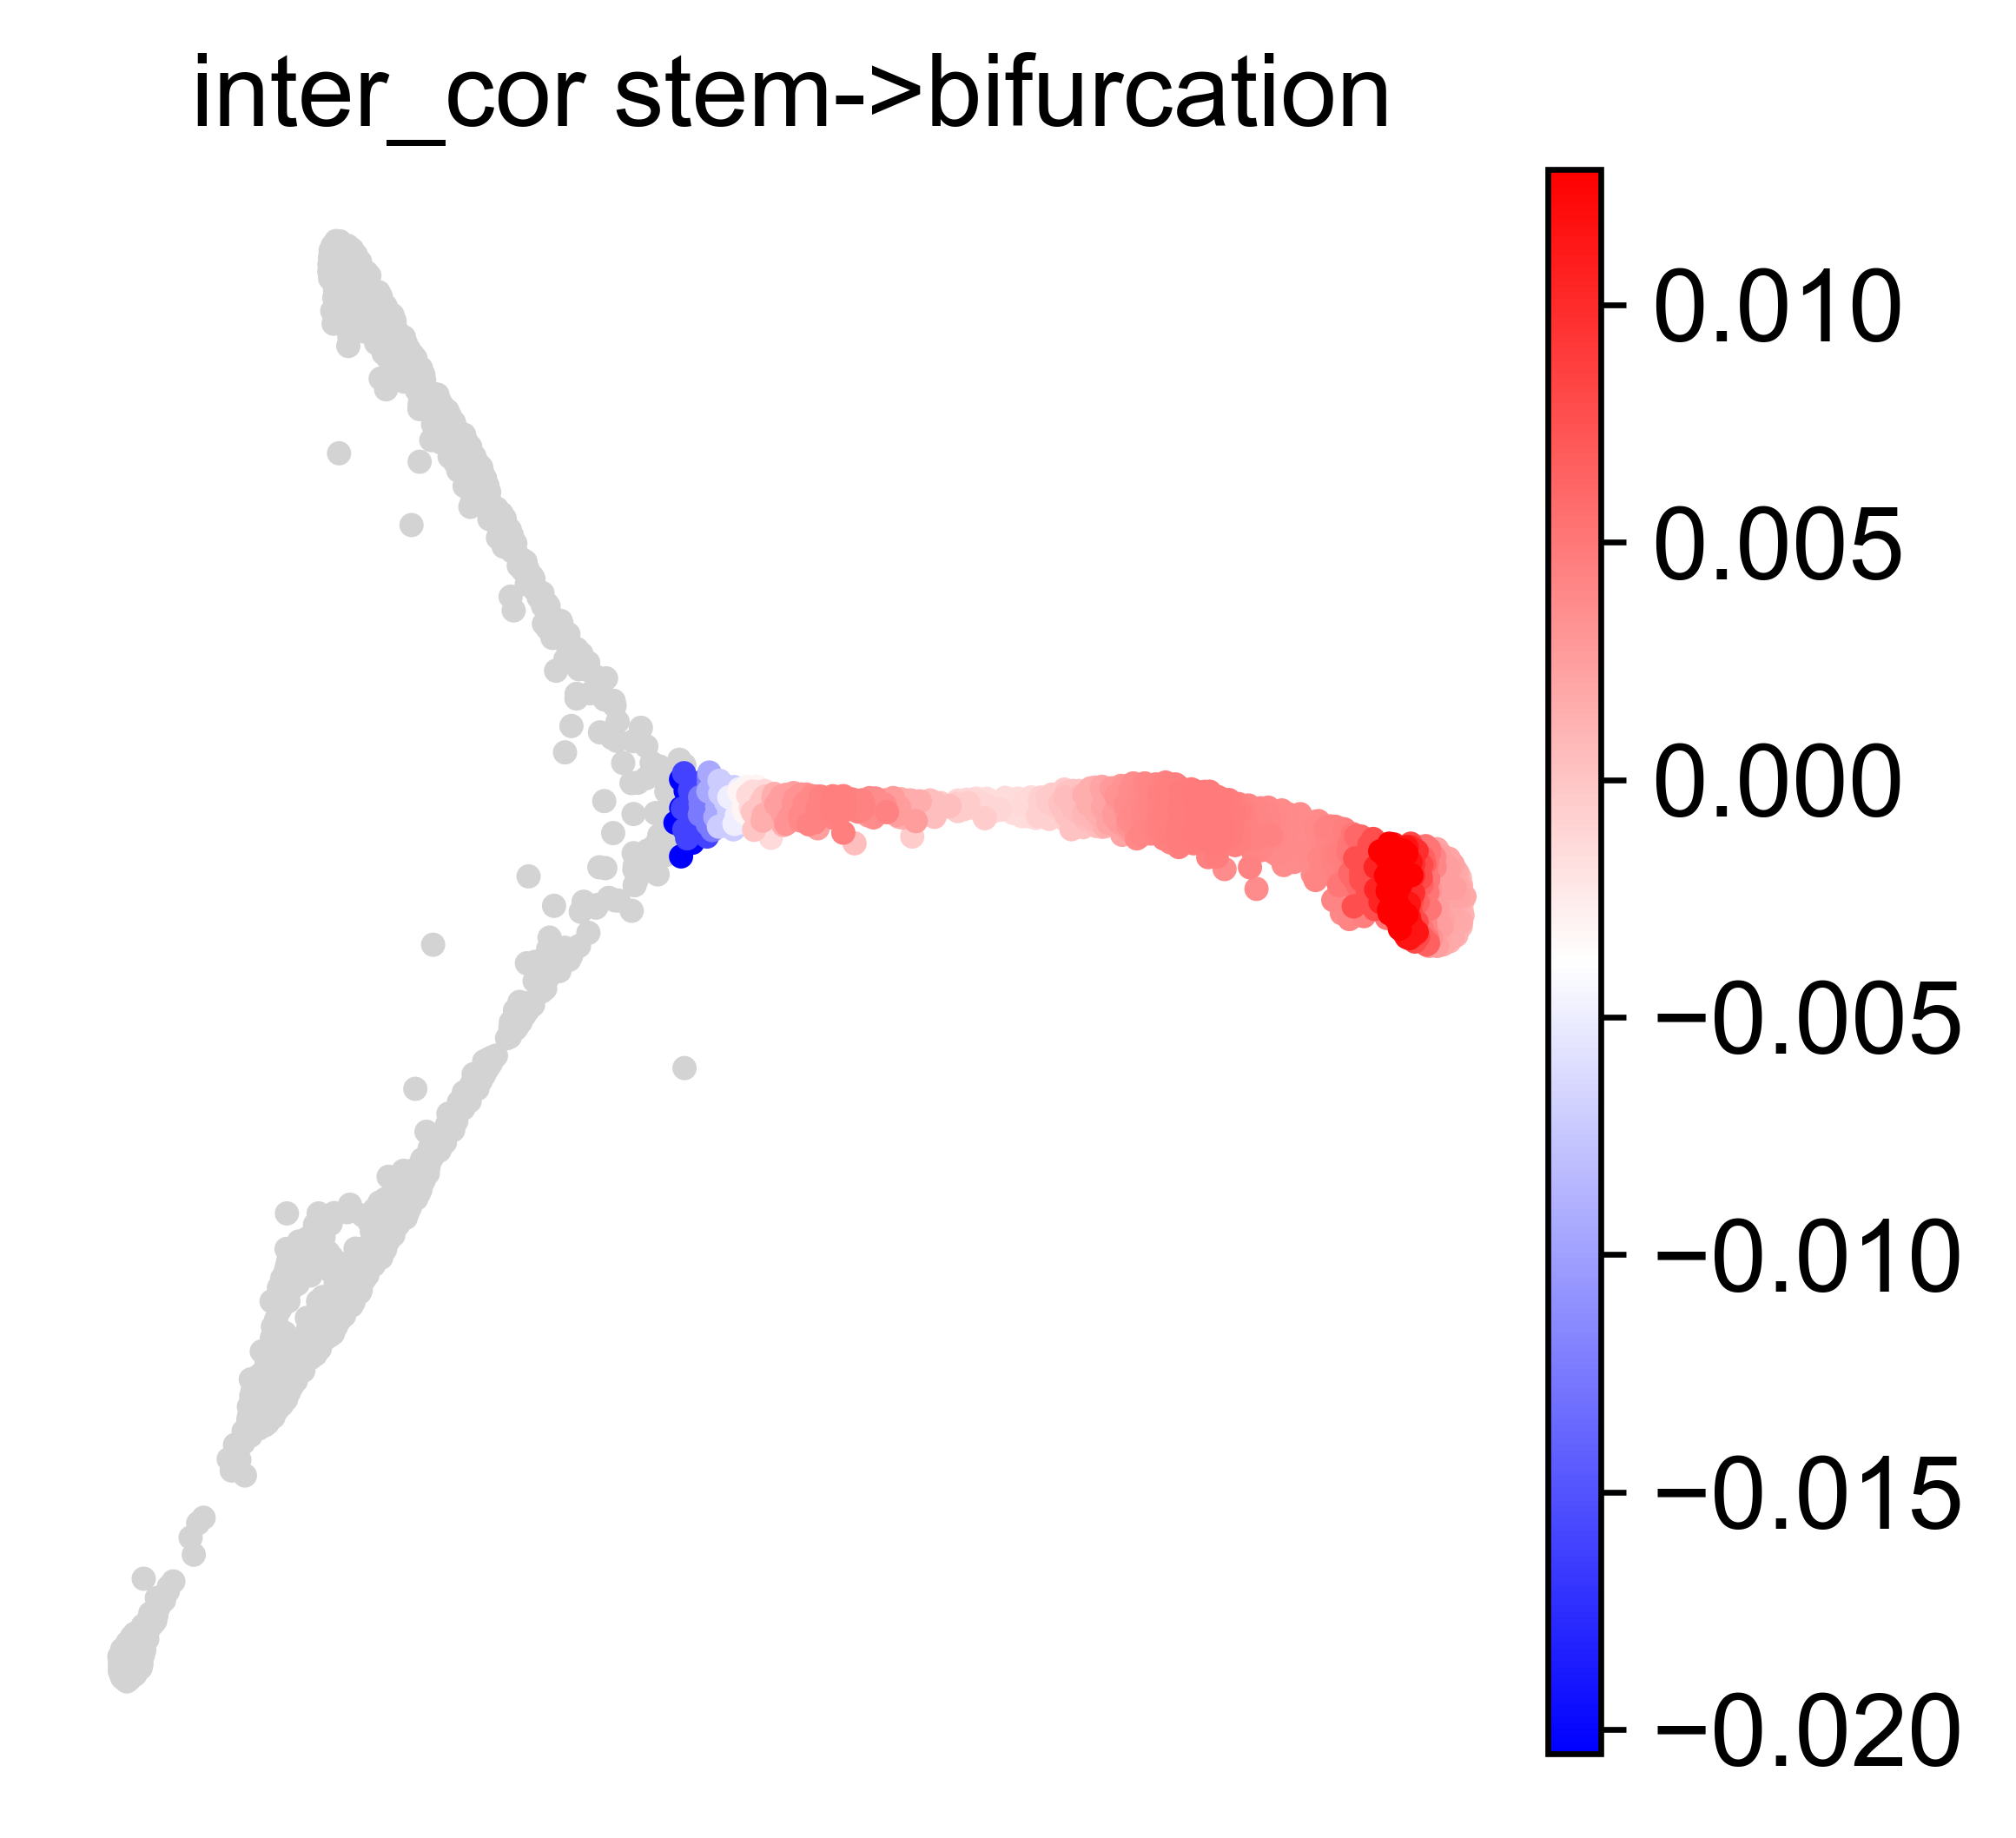

In [33]:
sc.pl.draw_graph(adata,color=f"inter_cor {root_milestone}->{'<>'.join(miles)}",cmap="bwr")

In [35]:
from scFates.tools.utils import getpath, ProgressParallel, get_X
import igraph
import numpy as np
import pandas as pd

w=50
step=15

graph = adata.uns["graph"]
res=adata.uns[f'{root_milestone}->{"<>".join(miles)}']['synchro']["real"][miles[0]]

edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
img = igraph.Graph()
img.add_vertices(
    np.unique(graph["pp_seg"][["from", "to"]].values.flatten().astype(str))
)
img.add_edges(edges)

dct = graph["milestones"]
keys = np.array(list(dct.keys()))
vals = np.array(list(dct.values()))

leaves = list(map(lambda leave: dct[leave], miles))
root = dct[root_milestone]

leave=leaves[0]
df = adata.obs.loc[:, ["t", "seg"]]
cells = getpath(img, root, graph["tips"], leave, graph, df)
cells = cells.sort_values("t").index
ww = np.arange(0, len(cells) - w, step)

cell_win=[cells[i : (i + w)] for i in ww]
cell_stats = [
pd.DataFrame(
    np.repeat(res.corAB[i].reshape(-1, 1), len(cell_win[i])),
    index=cell_win[i],
    columns=["corAB"],
)
    for i in range(len(cell_win))
]
cell_stats = pd.concat(cell_stats, axis=1)
cell_stats = cell_stats.T.groupby(level=0).mean().T
cell_stats["t"] = adata.obs.loc[cell_stats.index, "t"]

In [36]:
from scFates.tools.utils import getpath, ProgressParallel, get_X, importeR
from scFates import logging as logg
from scFates import settings
import pandas as pd
import sys
from joblib import delayed
Rpy2, R, rstats, rmgcv, Formula = importeR("performing bifurcation analysis")
check = [type(imp) == str for imp in [Rpy2, R, rstats, rmgcv, Formula]]

In [37]:


#l = loess(cell_stats.t, cell_stats.ci, span=loess_span)
#pred = l.predict(cell_stats.t, stderror=True)

m = rmgcv.gam(
    Formula("corAB ~ s(t, bs = 'cs',k=%s)" % 10),
    data=cell_stats,
)
pred, se = rmgcv.predict_gam(m, se_fit=True)

cell_stats["fit"] = pred

In [38]:
adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"]=np.nan
adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"].loc[cell_stats.index]=cell_stats.fit

/tmp/ipykernel_835761/1954740039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"].loc[cell_stats.index]=cell_stats.fit


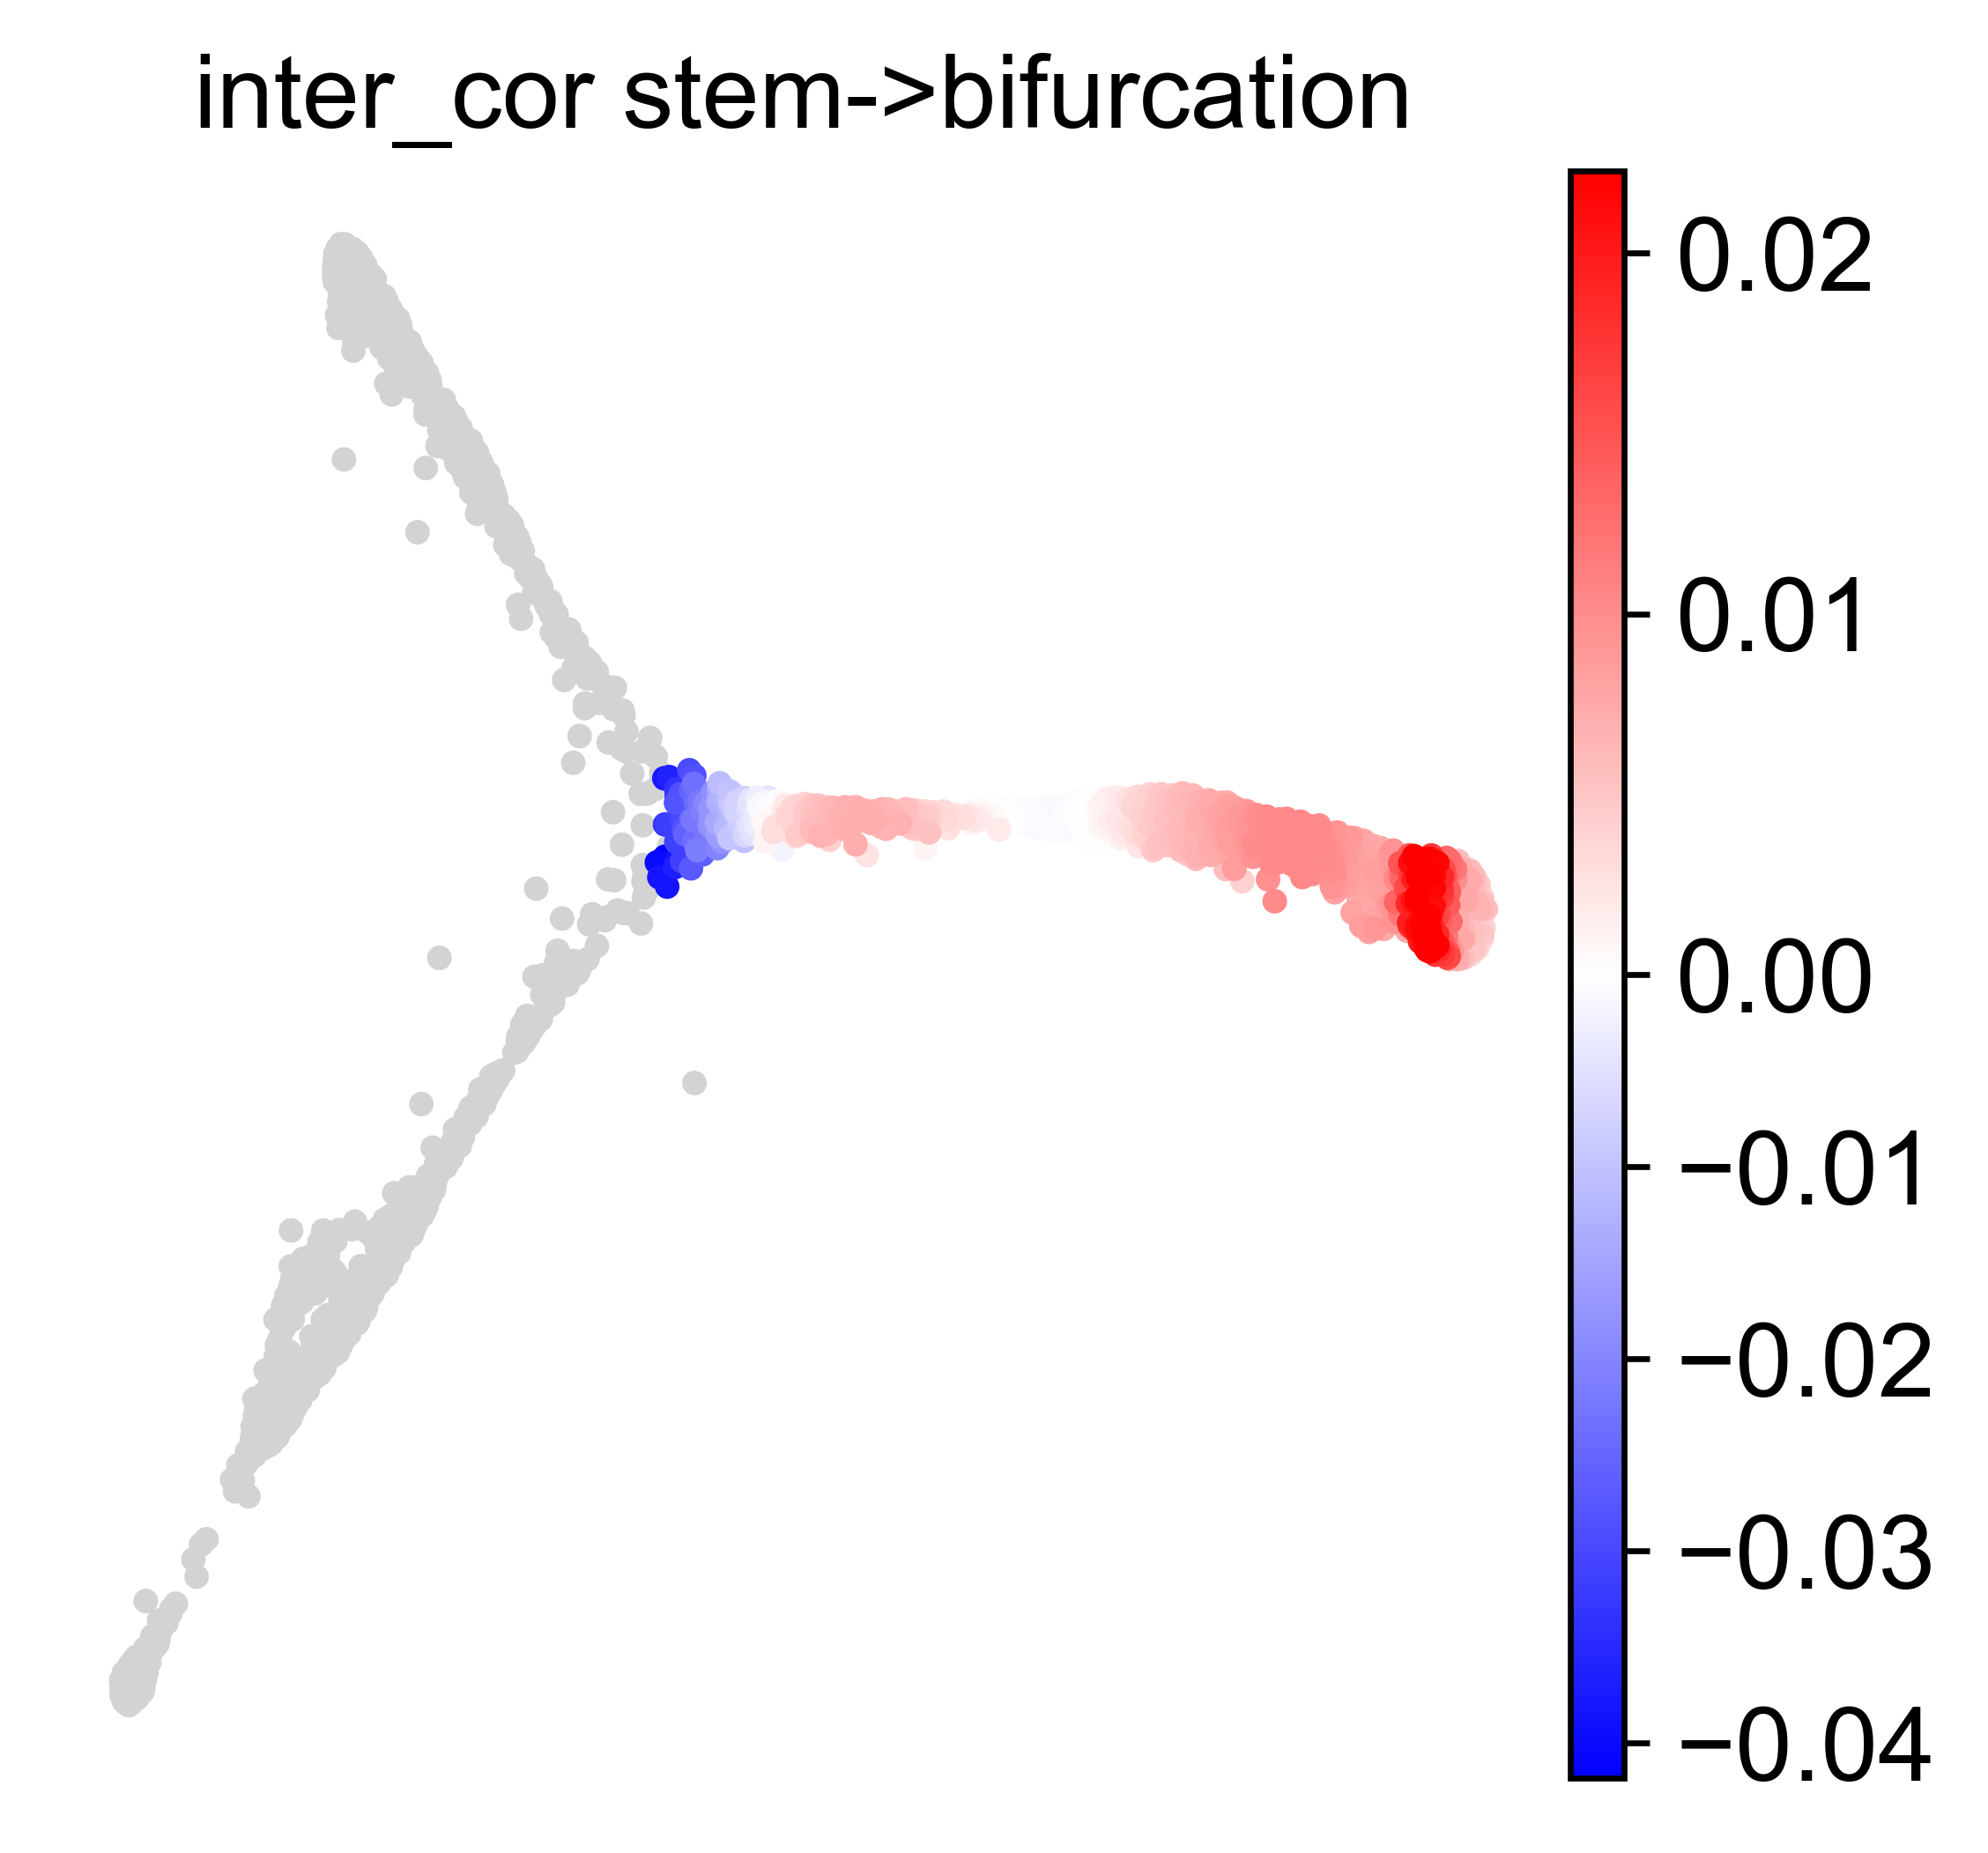

In [40]:
sc.pl.draw_graph(adata,color=f"inter_cor {root_milestone}->{'<>'.join(miles)}",cmap="bwr",vcenter=0)

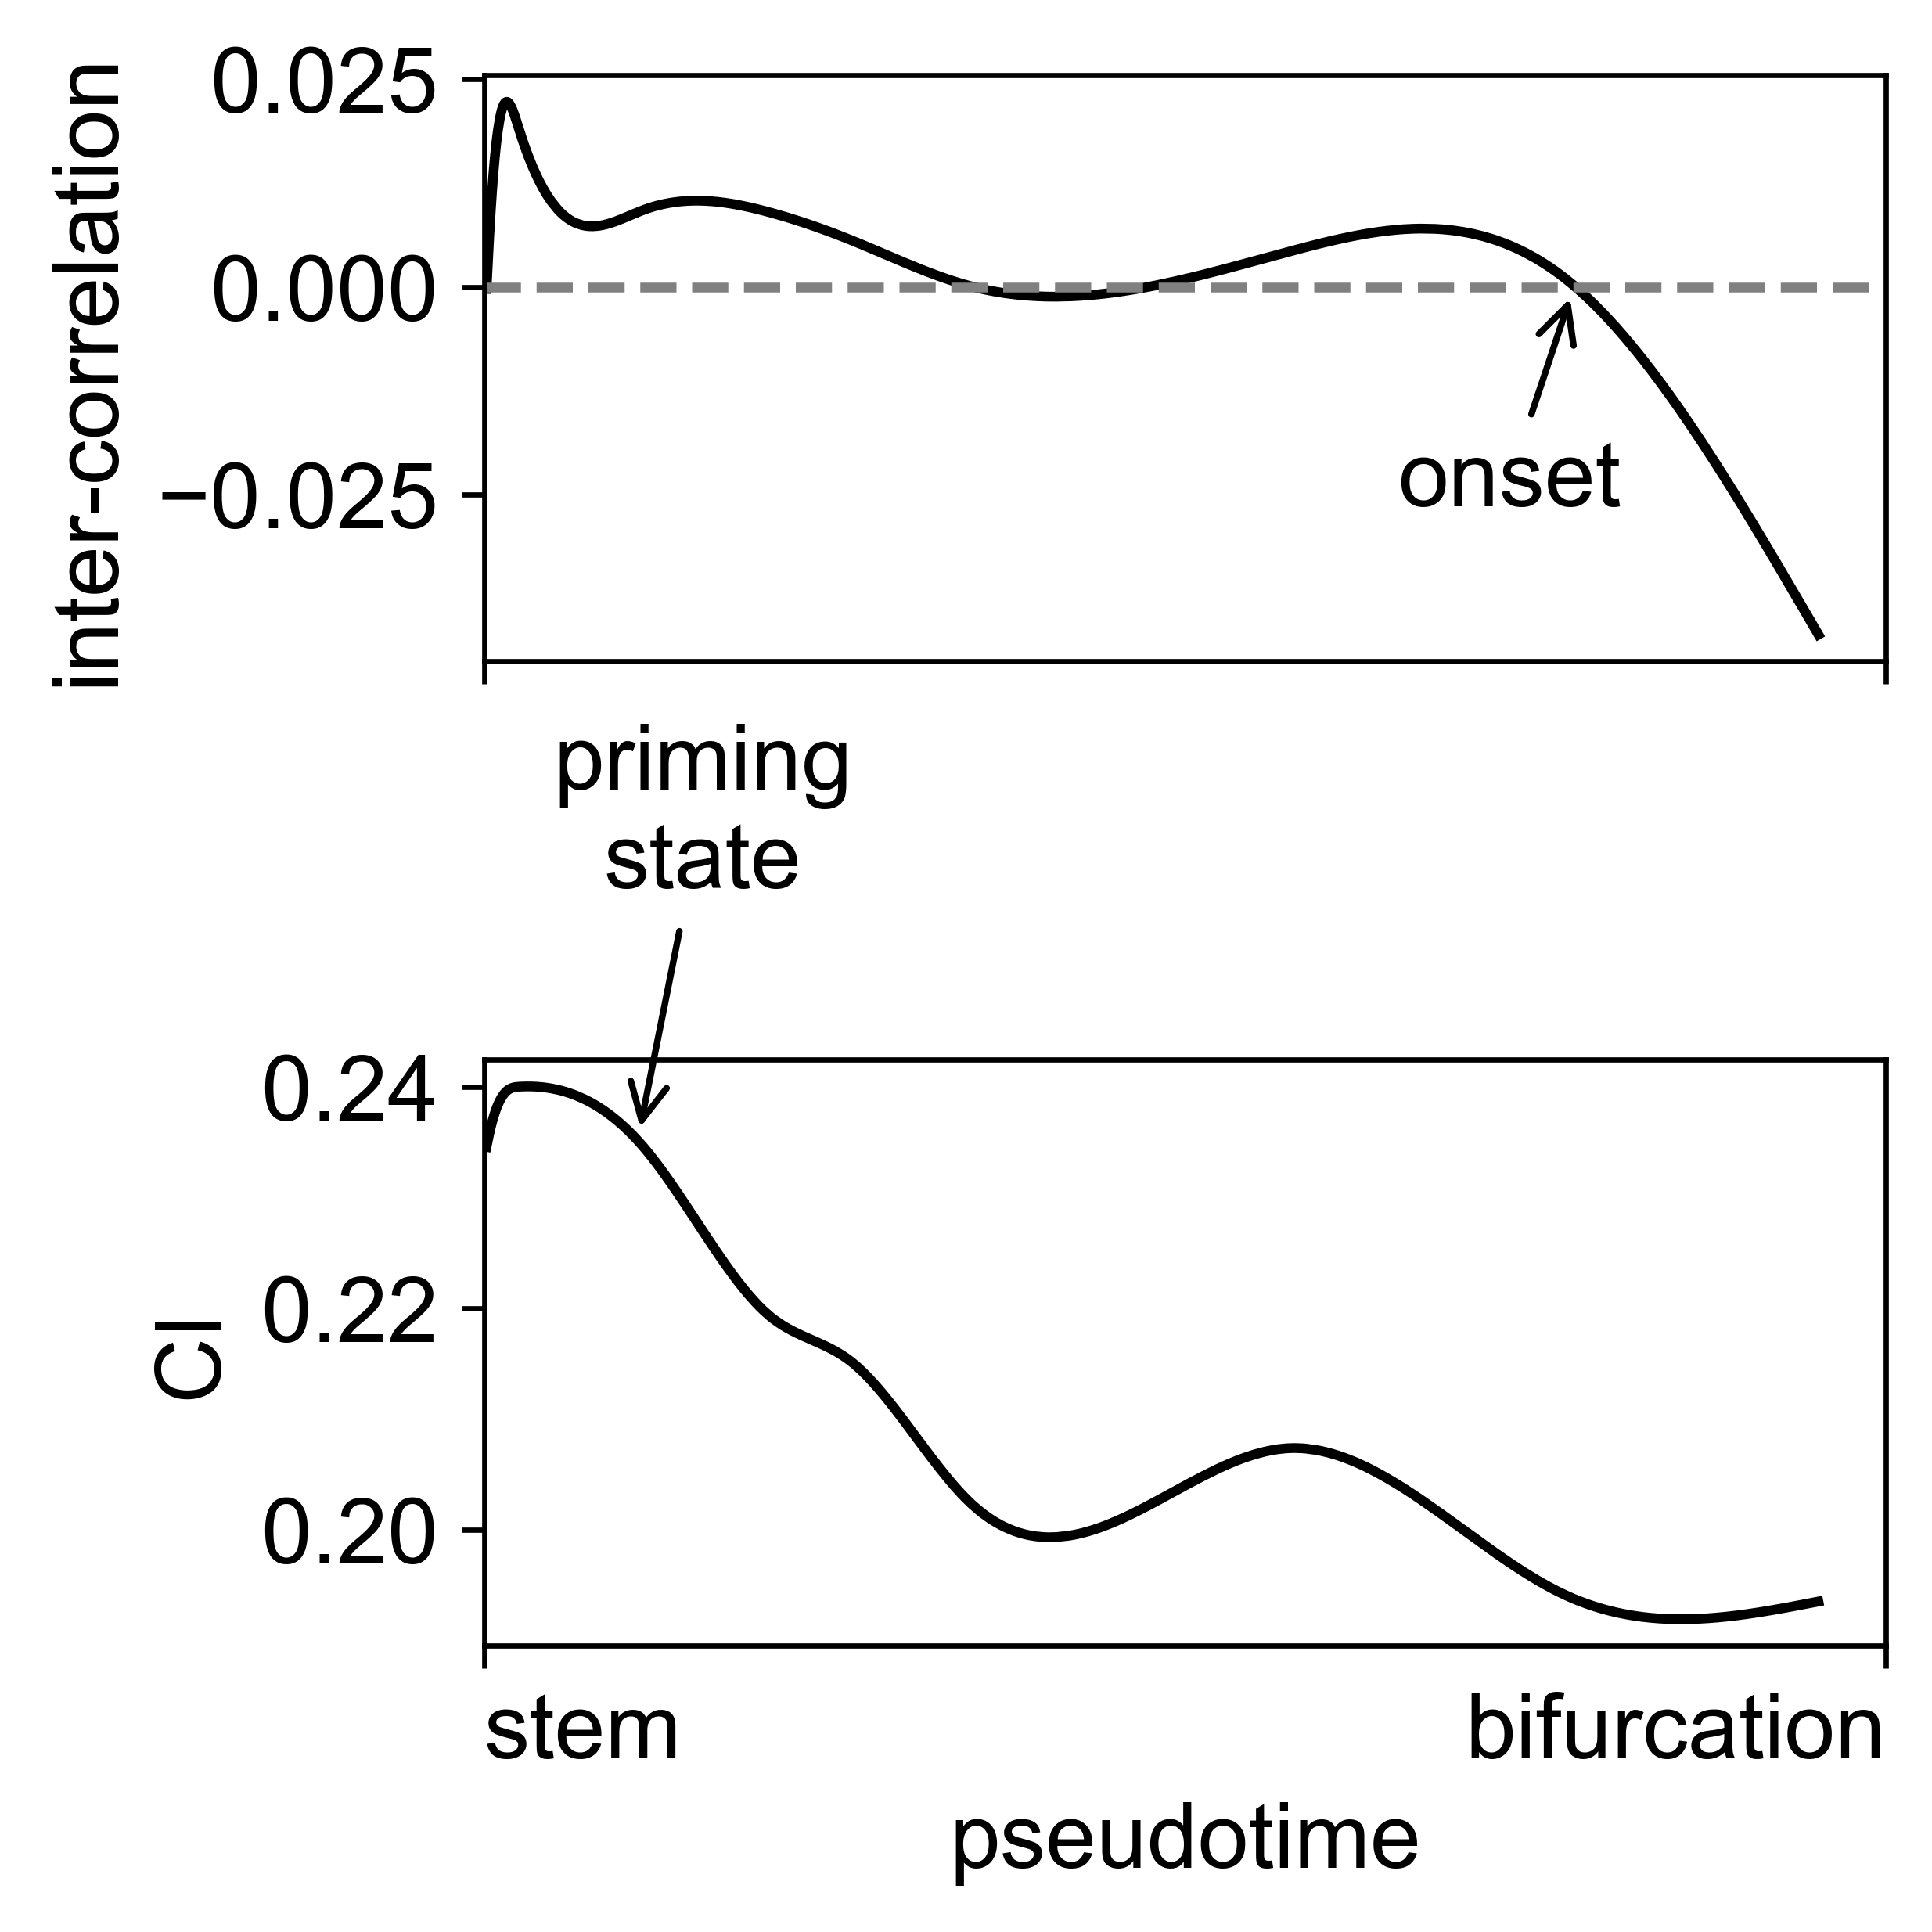

In [41]:
import matplotlib.pyplot as plt
import scvelo as scv
from matplotlib import cm
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

miles=["bifurcation"]
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(4,4),constrained_layout=True)

sel1=adata.obs_names[~adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"].isna()]
sel1=adata.obs.t[sel1].sort_values().index
ax1.plot(adata.obs.t[sel1],adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"][sel1],c="k")

df=adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"][sel1]
for idx, val in zip(df[::-1].index,df[::-1].values):
    if val>0:
        cell=idx
        break

ax1.annotate("onset",(adata.obs.t[cell],
                              adata.obs[f"inter_cor {root_milestone}->{'<>'.join(miles)}"][cell]),
            va="center",ha="center",xytext=(-10,-30),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))


miles=["bifurcation"]
sel2=adata.obs_names[~adata.obs[f"{root_milestone}->{'<>'.join(miles)} CI fitted"].isna()]
sel2=adata.obs.t[sel2].sort_values().index

ax2.plot(adata.obs.t[sel2],adata.obs[f"{root_milestone}->{'<>'.join(miles)} CI fitted"][sel2],c="k")

df=adata.obs[f"{root_milestone}->{'<>'.join(miles)} CI fitted"][sel2]
df=df[df.index.isin(adata.obs_names[adata.obs.t<2])]
df=df[df.index.isin(adata.obs_names[adata.obs.t>1.5])]

ax2.annotate("priming\nstate",(adata.obs.t[df.idxmin()],
                              adata.obs[f"{root_milestone}->{'<>'.join(miles)} CI fitted"][df.idxmin()]),
            va="center",ha="center",xytext=(10,50),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

ax1.set_ylabel("inter-correlation")
ax2.set_ylabel("CI")
ax2.set_xlabel("pseudotime")

ax2.set_xlim([0,tA])
ax2.set_xticks([0,tA],[root_milestone,"bifurcation"])

ax2.grid(False)
ax1.grid(False)
ax1.axhline(0,linestyle="--",c="grey")
xTick_objects = ax2.xaxis.get_major_ticks()

xTick_objects[0].label1.set_horizontalalignment('left')   # left align first tick 
xTick_objects[-1].label1.set_horizontalalignment('right')

plt.savefig("figures/CI_intercor1.pdf")

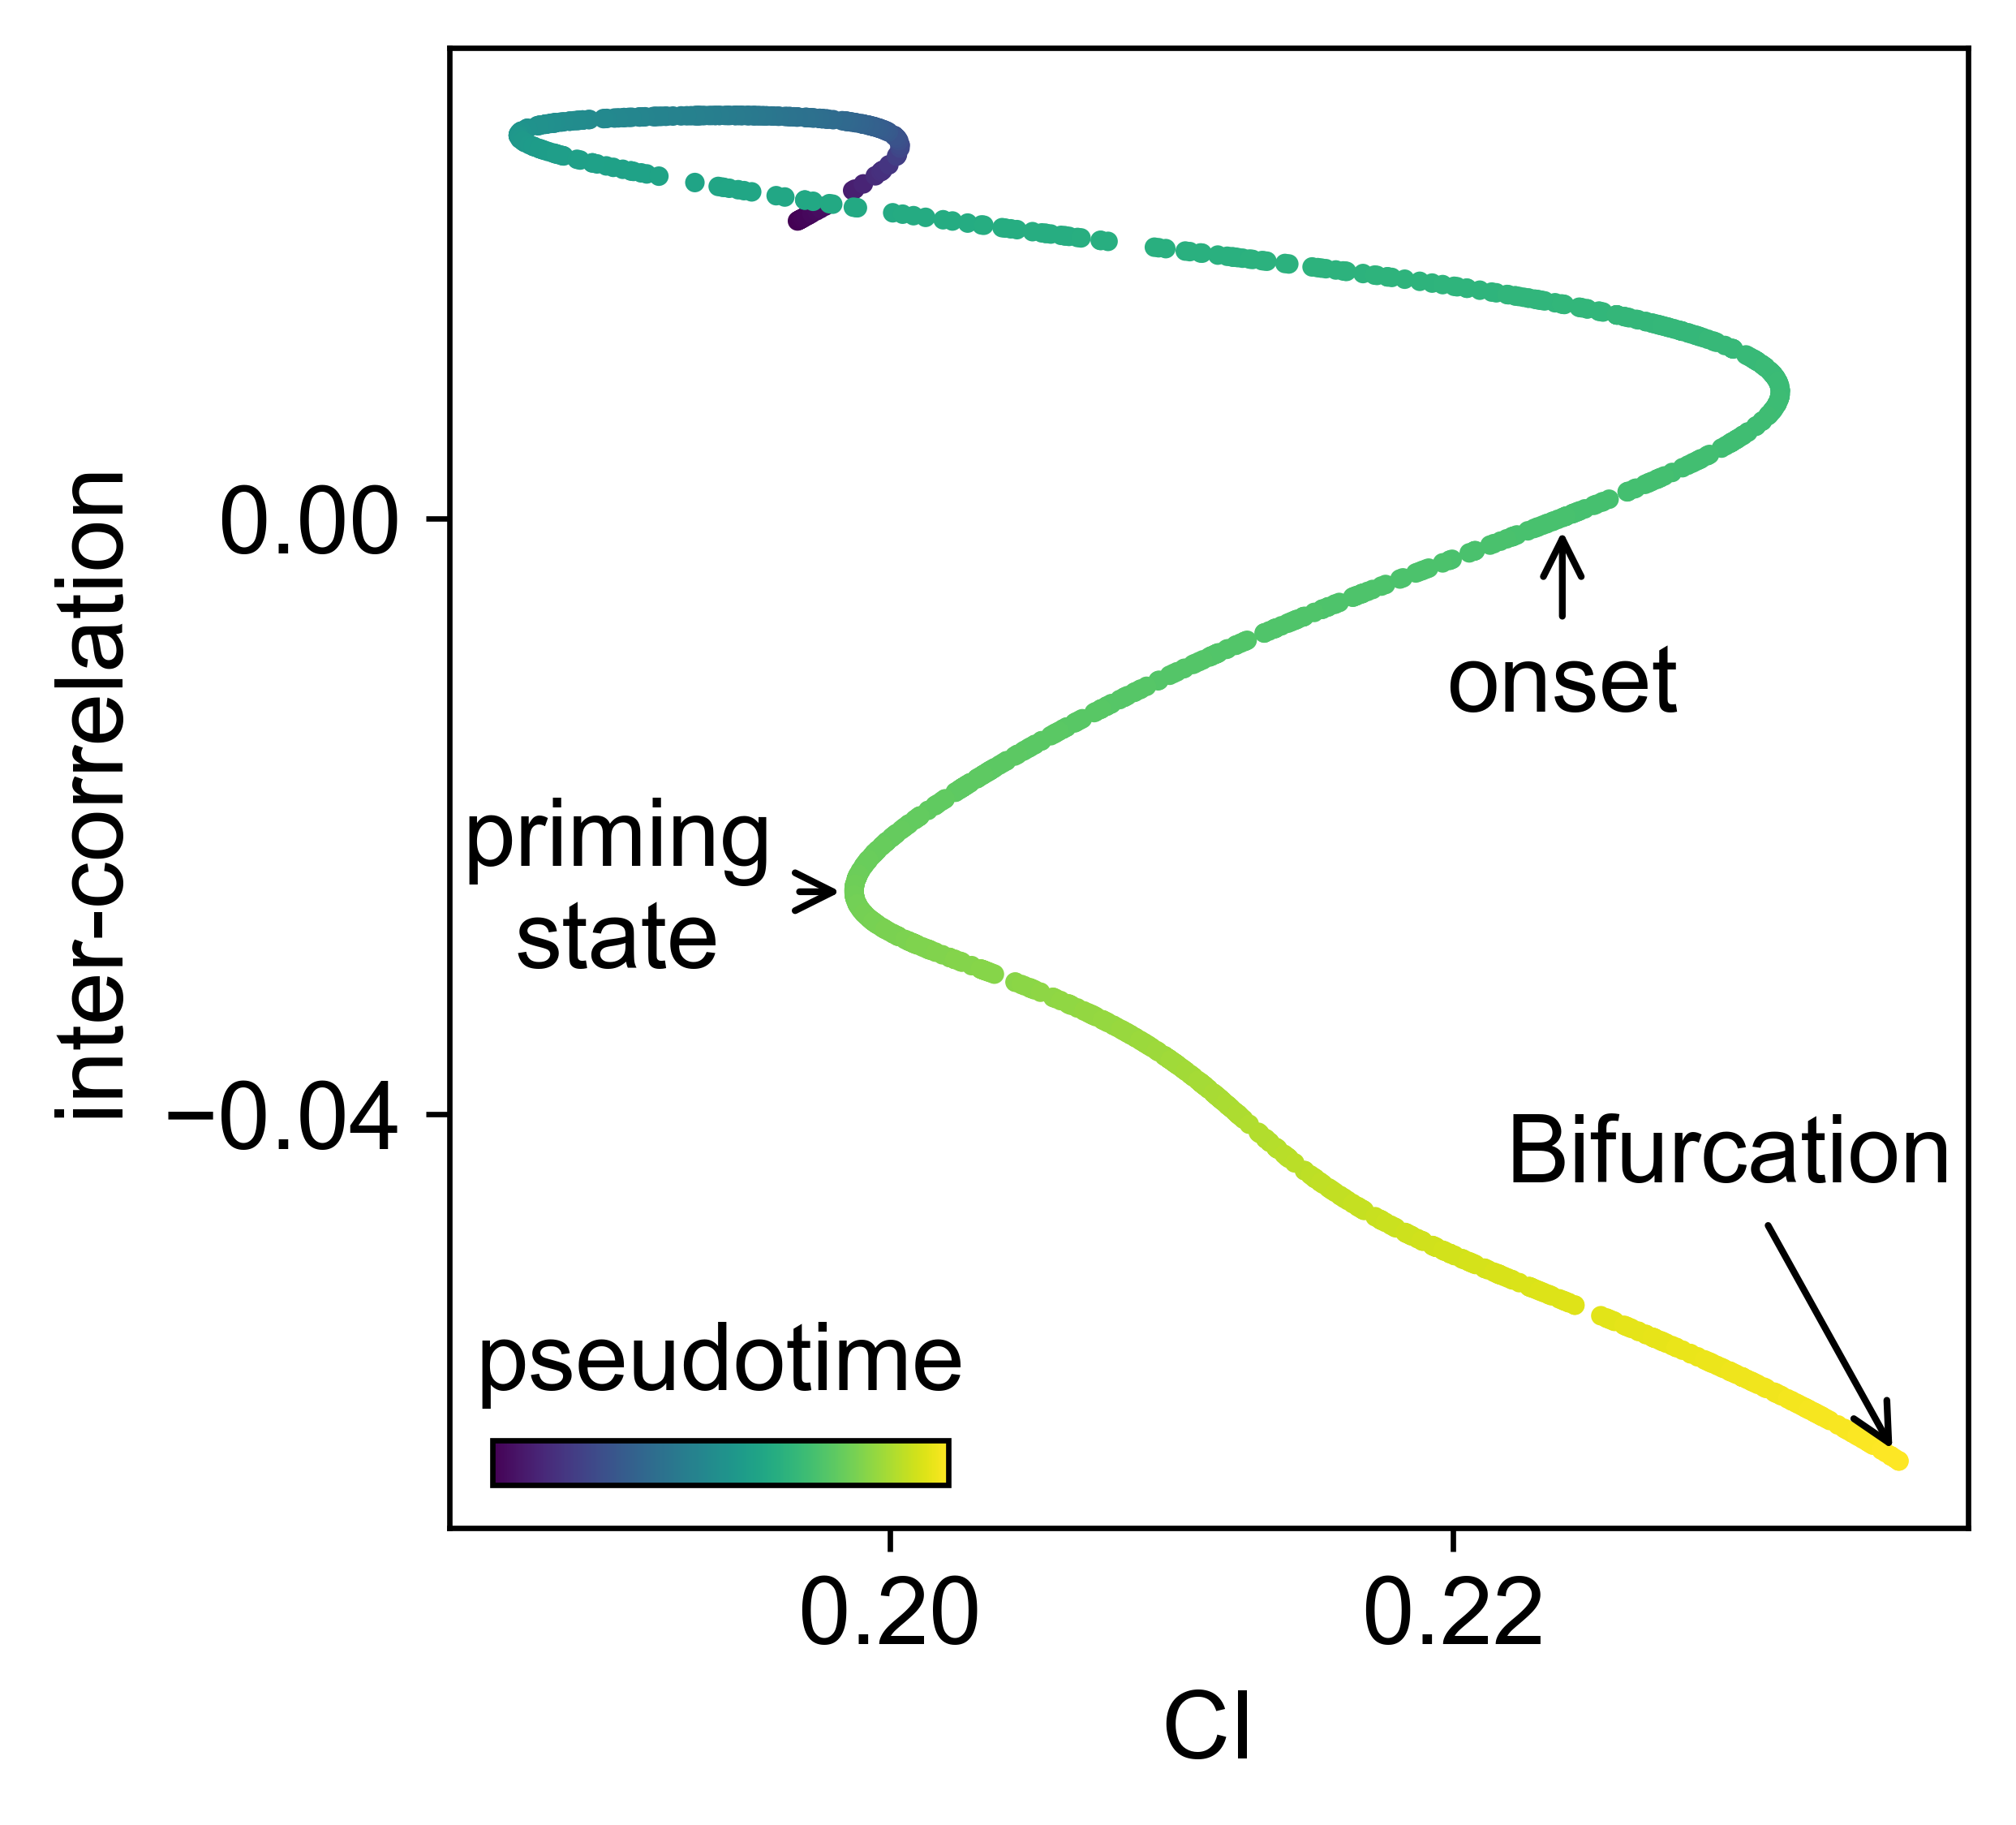

In [118]:
axbig=scv.pl.scatter(adata,y=f"inter_cor {root_milestone}->{miles[0]}",x=f"{root_milestone}->{miles[0]} CI fitted",
               color="t",show=False,colorbar=False,title="")

axbig.annotate("priming\nstate",(adata.obs[f"{root_milestone}->{miles[0]} CI fitted"][df.idxmin()],
                               adata.obs[f"inter_cor {root_milestone}->{miles[0]}"][df.idxmin()]),
            va="center",ha="center",xytext=(-35,0),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

axbig.annotate("onset",(adata.obs[f"{root_milestone}->{miles[0]} CI fitted"][cell],
                               adata.obs[f"inter_cor {root_milestone}->{miles[0]}"][cell]),
            va="center",ha="center",xytext=(0,-25),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))
#axbig.set_ylim([-0.07,.012])
axbig.set_ylabel("inter-correlation")
axbig.set_xlabel("CI")

axbig.grid(False)
cbaxes = inset_axes(axbig, width="30%", height="3%",loc=3,
                      bbox_transform=axbig.transAxes) 

cb1 = matplotlib.colorbar.ColorbarBase(cbaxes, cmap=cm.viridis,
                                orientation='horizontal'  ,ticklocation="top",                    
                                ticks=[],label="pseudotime",
                                )


cell_fork=(adata.obs.t[np.intersect1d(sel1,sel2)]-tA).abs().idxmin()
axbig.annotate("Bifurcation",(adata.obs[f"{root_milestone}->{miles[0]} CI fitted"][cell_fork],
                   adata.obs[f"inter_cor {root_milestone}->{miles[0]}"][cell_fork]),
            va="center",ha="center",xytext=(-25,45),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'))

plt.savefig("figures/CI_intercor2.pdf")

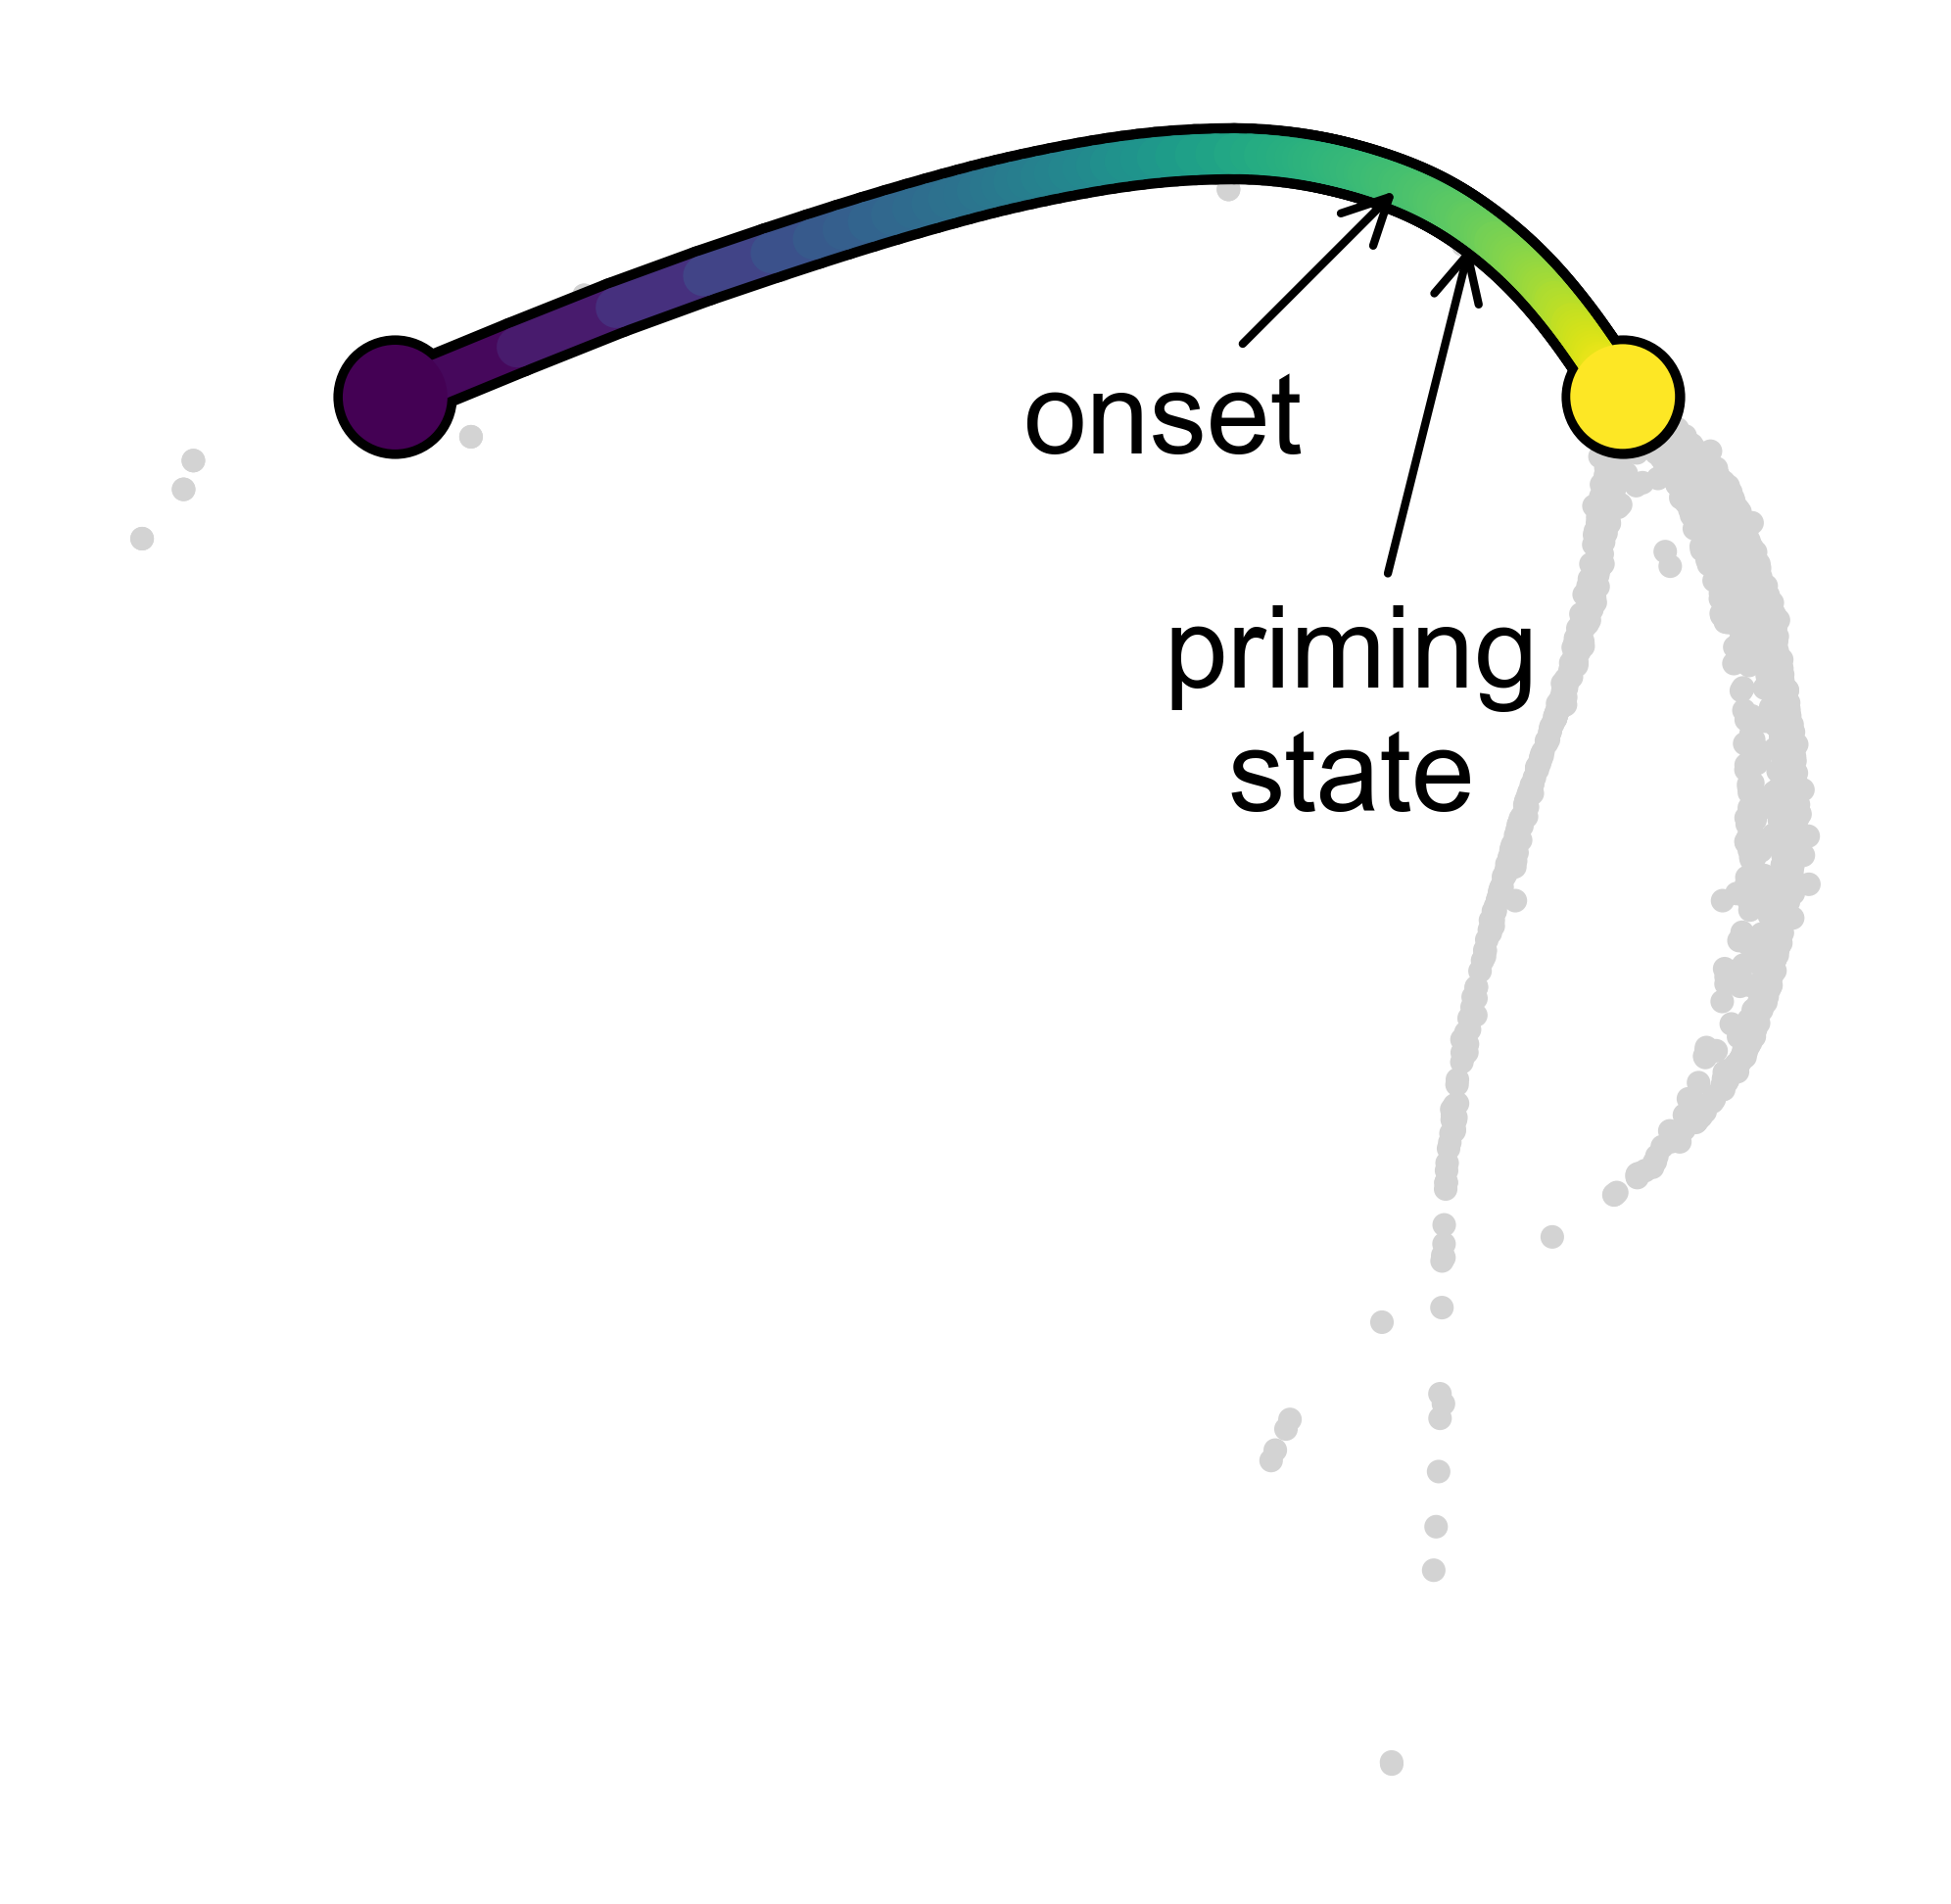

In [84]:
ax=scf.pl.trajectory(adata,"draw_graph_fa",root_milestone,[miles[0]],show=False)
ax.annotate("priming\nstate",(adata[df.idxmin()].obsm["X_draw_graph_fa"][:,0],adata[df.idxmin()].obsm["X_draw_graph_fa"][:,1]),
            va="center",ha="center",xytext=(-15,-60),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'),
            zorder=60000)

ax.annotate("onset",(adata[cell].obsm["X_draw_graph_fa"][:,0],adata[cell].obsm["X_draw_graph_fa"][:,1]),
            va="center",ha="center",xytext=(-30,-30),textcoords='offset points',arrowprops=dict(arrowstyle="->",facecolor='black'),
            zorder=60000)

plt.savefig("figures/CI_intercor3.pdf")